In [1]:
#%% Import Moduels

## System Tools
from _Public import *

import seaborn as sns
import matplotlib.backends.backend_pdf as figpdf
import matplotlib.dates as matdates
import pyfixest as pf
from binsreg import *

## Output Folder
OutputFolder = 'Micro_data/results/Analysis_PriceChange/'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
## Self-written Modules
import Toolkit_TimeSeries as MyTS
import Toolkit_Graphics as MyGR

# Load in the data

In [2]:
DataFolder = "Micro_data\\datasets\\SDC\\"

In [3]:
PriceChange = pd.read_pickle(DataFolder + "PriceChange.p")

## Clean the sample

In [4]:
# Generate relevant variables
PriceChange['Overlap_FL'] = (PriceChange['GapBusDays_F2L']<=1) * 1
PriceChange['Overlap_LI'] = (PriceChange['GapBusDays_L2I']<=1) * 1

In [5]:
PriceChange['FirstEventDate'] = PriceChange['FilingDate']
PriceChange['FirstEventDate'] = PriceChange['FirstEventDate'].where(PriceChange['ShelfIssueFlag'] == 0, PriceChange['LaunchDate'])

PriceChange['FirstEventDate_Quarter'] = PriceChange['FilingDate_Quarter']
PriceChange['FirstEventDate_Quarter'] = PriceChange['FirstEventDate_Quarter'].where(PriceChange['ShelfIssueFlag'] == 0, PriceChange['LaunchDate_Quarter'])

In [6]:
Var_F = 'PC_NonExcl_F'+'_FF1_PostEvent_F'
Var_I = 'PC_NonExcl_I'+'_FF1_PostEvent_I'
PriceChange['PC_PreVersion'] = PriceChange[Var_F]
PriceChange['Date_PreVersion'] = PriceChange['FilingDate_Quarter']
PriceChange.loc[PriceChange['ShelfIssueFlag'] == 1, 'PC_PreVersion'] = \
    PriceChange.loc[PriceChange['ShelfIssueFlag'] == 1, Var_I]
PriceChange.loc[PriceChange['ShelfIssueFlag'] == 1, 'Date_PreVersion'] = \
    PriceChange.loc[PriceChange['ShelfIssueFlag'] == 1, 'IssueDate_Quarter']

## Winsorize

In [7]:
TempVarList = ['PC_Total_Event', 'PC_FirstEvent', 's_Share', 's_Funding', 'PC_Runup', 'LogK', 'LogMV', ]
PctList = [0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995]

In [8]:
TempStat = PriceChange[TempVarList].describe(percentiles=PctList)
TempStat 

,PC_Total_Event,PC_FirstEvent,s_Share,s_Funding,PC_Runup,LogK,LogMV
count,3510.000000,3510.000000,3411.000000,3405.000000,3510.000000,3410.000000,3405.000000
mean,-0.045290,-0.033685,18.435262,0.228983,0.202190,5.351063,6.015504
std,0.124770,0.091525,982.017991,1.050107,0.518478,1.902246,1.657647
min,-1.417302,-0.567984,0.000000,0.000016,-3.220123,-2.302585,0.405465
0.5%,-0.542494,-0.400664,0.007451,0.009991,-1.541779,1.132831,1.548396
1%,-0.435046,-0.344860,0.013844,0.014423,-1.277270,1.553131,1.916923
5%,-0.248144,-0.178514,0.039829,0.038131,-0.559331,2.505109,3.192930
10%,-0.174237,-0.127032,0.057228,0.055638,-0.318454,3.086029,3.930252
25%,-0.095310,-0.068264,0.093640,0.088899,-0.039414,4.046991,4.975353
50%,-0.032889,-0.024989,0.148774,0.141440,0.178280,5.129011,6.032127


In [9]:
WinsorDict = {'s_Share': ('min', '95%'), 'PC_Total_Event': ('0.5%', '99.5%'), 'PC_FirstEvent': ('0.5%', '99.5%')}

In [10]:
# Winsorize the data 
TempFlag = True 
for vv in WinsorDict.keys():
    if TempFlag:
        SampleFlag = PriceChange[vv].between(TempStat.loc[WinsorDict[vv][0], vv], TempStat.loc[WinsorDict[vv][1], vv])
        TempFlag = False
    else:
        SampleFlag = SampleFlag & PriceChange[vv].between(TempStat.loc[WinsorDict[vv][0], vv], TempStat.loc[WinsorDict[vv][1], vv])

In [11]:
PriceChange.loc[SampleFlag, TempVarList].describe(percentiles=PctList)


,PC_Total_Event,PC_FirstEvent,s_Share,s_Funding,PC_Runup,LogK,LogMV
count,3178.000000,3178.000000,3178.000000,3174.000000,3178.000000,3137.000000,3174.000000
mean,-0.042558,-0.034496,0.162905,0.158821,0.201244,5.439057,6.168088
std,0.101215,0.076250,0.100710,0.249600,0.484941,1.876727,1.545777
min,-0.538878,-0.400478,0.000000,0.000016,-3.220123,-2.302585,1.335001
0.5%,-0.397295,-0.344438,0.007352,0.009892,-1.503098,1.511832,2.160183
1%,-0.361320,-0.287736,0.013357,0.014287,-1.216799,1.757858,2.528535
5%,-0.224860,-0.169765,0.038071,0.036273,-0.518280,2.653242,3.655840
10%,-0.162338,-0.124075,0.055872,0.054578,-0.292952,3.201117,4.246492
25%,-0.093361,-0.068144,0.090919,0.086970,-0.035050,4.128746,5.151990
50%,-0.033463,-0.025931,0.142149,0.136049,0.178758,5.201806,6.147399


In [12]:
PriceChange['SampleFlag'] = 0
PriceChange.loc[SampleFlag, 'SampleFlag'] = 1

In [13]:
pickle.dump(PriceChange, open(OutputFolder + "/PriceChange_Sample.p", "wb"))

In [14]:
DS = PriceChange.loc[SampleFlag, :].copy()

# Compare different price changes

## Relevance of different events

In [15]:
TempList = ['PC_NonExcl_'+vv for vv in ['F', 'L', 'I']] + ['PC_FirstEvent', 'PC_Total_Event']
PC_NonExcl_Stat = pd.concat([DS.groupby(['ShelfIssueFlag', 'Overlap_FL', 'Overlap_LI'])[vv] \
                            .apply(lambda x: KeyRetStat(x)).unstack(level=-1) for vv in TempList], \
                            axis=1, join='outer', keys=TempList).sort_index(axis=1)


In [16]:
PC_NonExcl_Stat.to_excel(OutputFolder+'PC_NonExcl_Stat.xlsx')

In [17]:
PC_NonExcl_MainStat = PC_NonExcl_Stat.loc[:, idx[:, ['count', 'mean', '50%']]].sort_index(axis=1) \
                                     .loc[:, idx[TempList, ['mean', '50%']]]

In [18]:
PC_NonExcl_MainStat

PC_NonExcl_F           PC_NonExcl_L  \
                                             mean       50%         mean   
ShelfIssueFlag Overlap_FL Overlap_LI                                       
0.0            0          0             -0.019825 -0.012217    -0.066192   
                          1             -0.014465 -0.007605    -0.068990   
               1          0             -0.024173 -0.019699    -0.024194   
                          1             -0.061159 -0.050856    -0.061159   
1.0            0          0             -0.004057 -0.002425    -0.036057   
                          1             -0.008451 -0.007128    -0.048770   
               1          0             -0.021186 -0.017272    -0.021567   
                          1             -0.036127 -0.038250    -0.035338   

                                               PC_NonExcl_I            \
                                           50%         mean       50%   
ShelfIssueFlag Overlap_FL Overlap_LI                                    
0.0            0          0          -0.045482    -0.017857 -0.023415   
                          1          -0.050509    -0.063182 -0.035490   
               1          0          -0.019764    -0.007349 -0.003122   
                          1          -0.050856    -0.056501 -0.045120   
1.0            0          0          -0.027548    -0.005958 -0.004325   
                          1          -0.038634    -0.045327 -0.036716   
               1          0          -0.017269    -0.016276 -0.010563   
                          1          -0.039170    -0.028460 -0.034871   

                                     PC_FirstEvent           PC_Total_Event  \
                                              mean       50%           mean   
ShelfIssueFlag Overlap_FL Overlap_LI                                          
0.0            0          0              -0.019825 -0.012217      -0.106816   
                          1              -0.014465 -0.007605      -0.080062   
               1          0              -0.024173 -0.019699      -0.031432   
                          1              -0.061159 -0.050856      -0.059728   
1.0            0          0              -0.036057 -0.027548      -0.041776   
                          1              -0.048770 -0.038634      -0.048366   
               1          0              -0.021567 -0.017269      -0.038202   
                          1              -0.035338 -0.039170      -0.029368   

                                                
                                           50%  
ShelfIssueFlag Overlap_FL Overlap_LI            
0.0            0          0          -0.100264  
                          1          -0.061993  
               1          0          -0.025981  
                          1          -0.045257  
1.0            0          0          -0.030791  
                          1          -0.039221  
               1          0          -0.028812  
                          1          -0.036053

In [19]:
PC_NonExcl_MainStat.to_latex(OutputFolder+'PC_NonExcl_MainStat.tex', float_format="%.3g", escape=True)

In [20]:
PC_NonExcl_MainStat_Share = PC_NonExcl_MainStat.copy()
for vv in TempList:
    for cc in ['mean', '50%']:
        PC_NonExcl_MainStat_Share.loc[:, (vv, cc)] = PC_NonExcl_MainStat.loc[:, (vv, cc)]/PC_NonExcl_MainStat.loc[:, ('PC_Total_Event', cc)]


In [21]:
PC_NonExcl_MainStat_Share

PC_NonExcl_F           PC_NonExcl_L  \
                                             mean       50%         mean   
ShelfIssueFlag Overlap_FL Overlap_LI                                       
0.0            0          0              0.185598  0.121853     0.619681   
                          1              0.180673  0.122668     0.861716   
               1          0              0.769082  0.758190     0.769726   
                          1              1.023961  1.123730     1.023961   
1.0            0          0              0.097105  0.078769     0.863094   
                          1              0.174738  0.181738     1.008356   
               1          0              0.554568  0.599464     0.564539   
                          1              1.230133  1.060948     1.203252   

                                               PC_NonExcl_I            \
                                           50%         mean       50%   
ShelfIssueFlag Overlap_FL Overlap_LI                                    
0.0            0          0           0.453627     0.167176  0.233531   
                          1           0.814761     0.789165  0.572489   
               1          0           0.760689     0.233815  0.120183   
                          1           1.123730     0.945962  0.996991   
1.0            0          0           0.894669     0.142606  0.140446   
                          1           0.985044     0.937164  0.936136   
               1          0           0.599363     0.426038  0.366638   
                          1           1.086462     0.969064  0.967228   

                                     PC_FirstEvent           PC_Total_Event  \
                                              mean       50%           mean   
ShelfIssueFlag Overlap_FL Overlap_LI                                          
0.0            0          0               0.185598  0.121853            1.0   
                          1               0.180673  0.122668            1.0   
               1          0               0.769082  0.758190            1.0   
                          1               1.023961  1.123730            1.0   
1.0            0          0               0.863094  0.894669            1.0   
                          1               1.008356  0.985044            1.0   
               1          0               0.564539  0.599363            1.0   
                          1               1.203252  1.086462            1.0   

                                           
                                      50%  
ShelfIssueFlag Overlap_FL Overlap_LI       
0.0            0          0           1.0  
                          1           1.0  
               1          0           1.0  
                          1           1.0  
1.0            0          0           1.0  
                          1           1.0  
               1          0           1.0  
                          1           1.0

In [22]:
PC_NonExcl_MainStat_Share.to_latex(OutputFolder+'PC_NonExcl_MainStat_Share.tex', float_format="%.3g", escape=True)

## Comparing different measures

In [23]:
# A unit function to compute the key statistics of various measures of price change
def UnitFun_Stat_PC(df, RetVar, WeightVar='s_Share', DateVar='IssueDate_Quarter'):
    """
    Compute the key statistics of various measures of price change
    """
    StatNameList = ['count', 'mean', 'mean_weighted_pooled', 'mean_weighted_crosstime', 'std', \
                    'Frac_0', 'Frac_Neg', 'Frac_Pos', \
                    'min', '1%', '10%', '25%', '50%', '75%', '90%', '99%', 'max'] 
    # Pooled sample
    ## The statistics from KeyRetStat 
    Stat_KeyRet = KeyRetStat(df[RetVar])

    ## Weighted average 
    Stat_WAvg_Pooled = WeightedMean(df, [RetVar], WeightVar).rename(index={RetVar: 'mean_weighted_pooled'})

    # Cross-time average of the cross-sectional average 
    Stat_WAvg_CrossTime = df.groupby(DateVar).apply(WeightedMean, [RetVar], WeightVar, include_groups=False) \
                            .mean().rename(index={RetVar: 'mean_weighted_crosstime'})

    # Combine the statistics 
    Stat_Summary = pd.concat([Stat_KeyRet, Stat_WAvg_Pooled, Stat_WAvg_CrossTime], axis=0).rename(RetVar) \
                    .loc[StatNameList]  
    
    return Stat_Summary


In [24]:
PC_List = ['PC_Total_Event', 'PC_FirstEvent', 'PC_NonExcl_F', 'PC_NonExcl_L', 'PC_NonExcl_I'] 
FilterTypeList = ['Level', 'FF5_PreEvent_F', 'FF5_PostEvent_I']
ColIdx = pd.MultiIndex.from_product([PC_List, FilterTypeList], names=['PC', 'FilterType'])

PC_Stat_Summary = pd.concat([UnitFun_Stat_PC(DS, col[0] if col[1]=='Level' else '_'.join(col)) for col in ColIdx], axis=1, keys=ColIdx)

In [25]:
PC_Stat_Summary

PC                      PC_Total_Event                                 \
FilterType                       Level FF5_PreEvent_F FF5_PostEvent_I   
count                      3178.000000    3178.000000     3178.000000   
mean                         -0.042558      -0.046614       -0.039351   
mean_weighted_pooled         -0.048951      -0.052871       -0.045637   
mean_weighted_crosstime      -0.043061      -0.047287       -0.039195   
std                           0.101215       0.098725        0.097044   
Frac_0                        0.009440       0.012587        0.009125   
Frac_Neg                      0.667401       0.683763        0.662052   
Frac_Pos                      0.323159       0.303650        0.328823   
min                          -0.538878      -0.500581       -0.595831   
1%                           -0.361320      -0.363664       -0.347714   
10%                          -0.162338      -0.168361       -0.156882   
25%                          -0.093361      -0.095946       -0.088118   
50%                          -0.033463      -0.036385       -0.030592   
75%                           0.017995       0.013004        0.018193   
90%                           0.071106       0.061023        0.066879   
99%                           0.180709       0.167098        0.176786   
max                           0.318757       0.336382        0.312891   

PC                      PC_FirstEvent                                 \
FilterType                      Level FF5_PreEvent_F FF5_PostEvent_I   
count                     3178.000000    3178.000000     3178.000000   
mean                        -0.034496      -0.036704       -0.032573   
mean_weighted_pooled        -0.038443      -0.040491       -0.036453   
mean_weighted_crosstime     -0.034613      -0.036793       -0.032256   
std                          0.076250       0.073894        0.073353   
Frac_0                       0.035557       0.012587        0.012272   
Frac_Neg                     0.683134       0.712398        0.694462   
Frac_Pos                     0.281309       0.275016        0.293266   
min                         -0.400478      -0.484610       -0.393366   
1%                          -0.287736      -0.275057       -0.282132   
10%                         -0.124075      -0.123925       -0.116323   
25%                         -0.068144      -0.069626       -0.066433   
50%                         -0.025931      -0.027863       -0.024585   
75%                          0.005720       0.003523        0.005888   
90%                          0.042682       0.039460        0.042081   
99%                          0.145087       0.140294        0.146916   
max                          0.272867       0.275917        0.260538   

PC                      PC_NonExcl_F                                 \
FilterType                     Level FF5_PreEvent_F FF5_PostEvent_I   
count                    3178.000000    3178.000000     3178.000000   
mean                       -0.022407      -0.025753       -0.021016   
mean_weighted_pooled       -0.024659      -0.028099       -0.023402   
mean_weighted_crosstime    -0.023103      -0.026552       -0.021393   
std                         0.081512       0.079292        0.078531   
Frac_0                      0.038704       0.012587        0.013845   
Frac_Neg                    0.628068       0.671806        0.648521   
Frac_Pos                    0.333228       0.315607        0.337634   
min                        -0.505977      -0.418989       -0.408879   
1%                         -0.255553      -0.248852       -0.232488   
10%                        -0.099372      -0.101118       -0.092534   
25%                        -0.054683      -0.056604       -0.052190   
50%                        -0.016127      -0.019174       -0.016218   
75%                         0.010991       0.008330        0.011910   
90%                         0.046725       0.039460        0.043518   
99%                         0.145087

In [26]:
PC_Stat_Summary.to_excel(OutputFolder+'/PC_Stat_Summary.xlsx')

# Historgram of key variables of interest 

In [27]:
def UnitPlot_Hist(df, bins=15, XLimit=[], YLimit=[], XLabel=r'$\Delta p$', YLabel="Probability"):
    Fig = MyGR.Setup_Fig(FigSize=(1/5 * 2, 1/6 * 2))
    ax = Fig.add_subplot(1,1,1)
    # TempSample.loc[tempind, vv].hist(ax=ax, bins=15)
    counts, bins = np.histogram(df, bins=bins)
    probabilities = counts / counts.sum()
    plt.bar(bins[:-1], probabilities, width=np.diff(bins), edgecolor='black', facecolor=MyGR.MyColor('Blue'), align='edge')
    ax.vlines(0, 0, ax.get_ylim()[1], color=MyGR.MyColor('Red'), linestyle='--')
    if len(XLimit) > 0:
        ax.set_xlim(XLimit)
    if len(YLimit) > 0:
        ax.set_ylim(YLimit)
    ax.set_xlabel(XLabel, fontsize=6)
    ax.set_ylabel(YLabel, fontsize=6)
    # for spine in ax.spines.values():
    #     spine.set_color('black')
    MyGR.Setup_Ax(ax, XTickNbins=7, YTickNbins=7)
    # plt.tick_params(axis='both', length=3, width=1, direction='in', labelsize=5)
    plt.tight_layout()

    return Fig, ax 


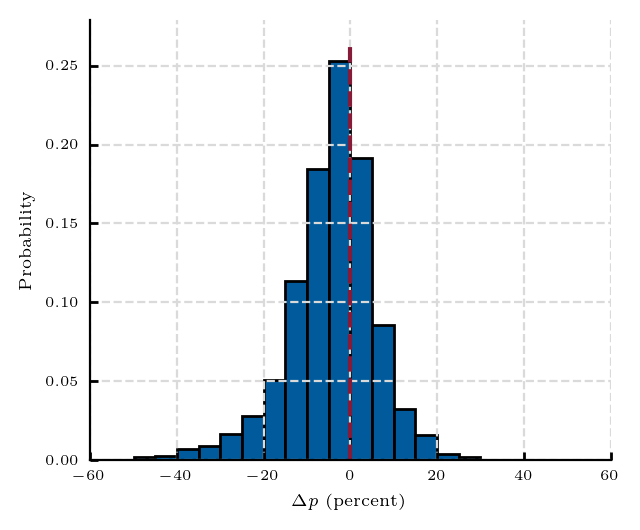

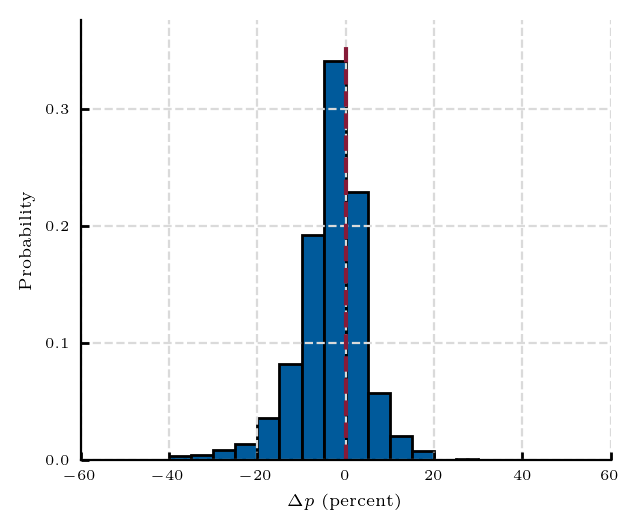

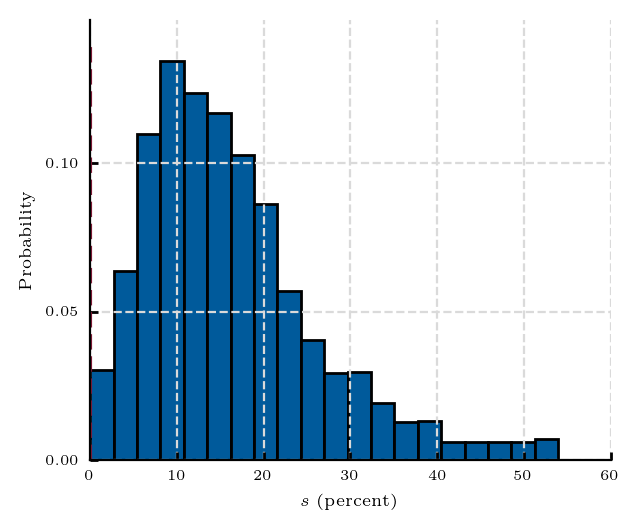

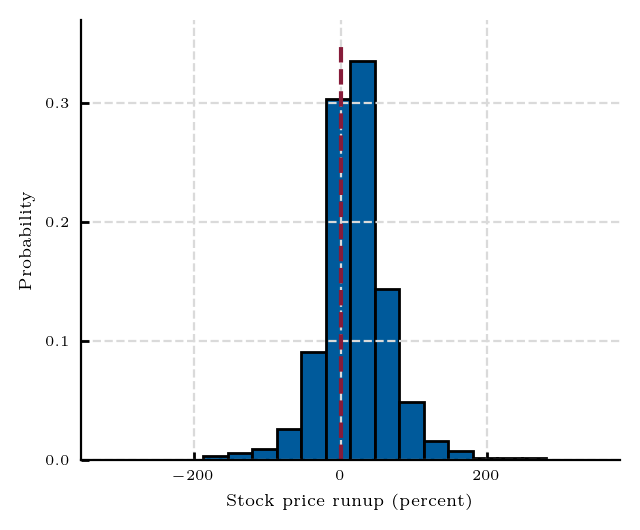

In [28]:
TempDict = {'PC_Total_Event': {'XLabel': r'$\Delta p$ (percent)', 'YLabel': "Probability", 'XLimit': [-60, 60], "Bins": np.arange(-60, 65, 5)}, \
            'PC_FirstEvent': {'XLabel': r'$\Delta p$ (percent)', 'YLabel': "Probability", 'XLimit': [-60, 60], "Bins": np.arange(-60, 65, 5)}, \
            's_Share': {'XLabel': r'$s$ (percent)', 'YLabel': "Probability", 'XLimit': [0, 60], "Bins": 20}, \
            'PC_Runup': {'XLabel': r'Stock price runup (percent)', 'YLabel': "Probability", 'XLimit': [], "Bins": 20}}

for kk, vv in TempDict.items():
    Fig, _ =UnitPlot_Hist(DS[kk]*100, XLabel=vv['XLabel'], YLabel="Probability", XLimit=vv['XLimit'], YLimit=[], bins=vv['Bins'])
    plt.show()
    Fig.savefig(OutputFolder+'Hist_'+kk+'.eps', format='eps', dpi=1000)


# Key cross-sectional correlation

## Common functions

In [29]:
def UnitFun_BinScatterData(df, xx, yy):
    temp_est = binsreg(yy, xx, data=df)
    temp_data = temp_est.data_plot[0].dots
    return temp_data[['x', 'fit']]

In [30]:
def UnitFun_BinScatterPlot(DataForBinScatter, BinScatterData, xx, yy, \
                           XLimit=[0,1], YLimit=[], \
                           XLabel=r's', YLabel=r'$\Delta p$'):
    
    # Linear fitting based on the binned data
    tempdf = BinScatterData[(xx, yy)].copy().dropna()
    temp_x = tempdf['x']
    temp_y = tempdf['fit']

    m_bin = sm.OLS(temp_y, sm.add_constant(temp_x)).fit()
    temp_y_pre = m_bin.predict(sm.add_constant(temp_x))
    coef_bin = m_bin.params['x']

    # Linear fitting based on the original data
    temp_df_orig = DataForBinScatter.loc[:, [xx, yy]].dropna().copy().sort_values(by=xx)
    temp_x_orig = temp_df_orig[xx] 
    temp_y_orig = temp_df_orig[yy]

    m_orig = sm.OLS(temp_y_orig, sm.add_constant(temp_x_orig)).fit()
    temp_y_orig_pre = m_orig.predict(sm.add_constant(temp_x_orig))
    coef_orig = m_orig.params[xx]

    Fig = MyGR.Setup_Fig()
    ax = Fig.add_subplot(1,1,1)
    ax.scatter(temp_x, temp_y, s=3, color=MyGR.MyColor('Blue'))
    MyGR.Line(Width=2).Plot(temp_x, temp_y_pre, ax=ax, Label="Regression line: binned data, coef={:.3g}".format(coef_bin))
    MyGR.Line(Width=2, Color=MyGR.MyColor('Red')).Plot(temp_x_orig, temp_y_orig_pre, ax=ax, Label="Regression line: original data, coef={:.3g}".format(coef_orig))
    if not XLimit:
        XMin = min(temp_x.loc[temp_x<=1].min())
        XMax = max(temp_x.loc[temp_x<=1].max())
        XLimit = [XMin-0.005, XMax+0.005]
    ax.set_xlim(XLimit)
    if not YLimit:
        YMin = min(temp_y.loc[temp_x<=1].min(), temp_y_pre.loc[temp_x<=1].min())
        YMax = max(temp_y.loc[temp_x<=1].max(), temp_y_pre.loc[temp_x<=1].max())
        YLimit = [YMin-0.005, YMax+0.005]

    ax.set_ylim(YLimit)
    plt.legend(loc='best', fontsize=6)
    ax.set_xlabel(XLabel, fontsize=8) 
    ax.set_ylabel(YLabel, fontsize=8)
    ax.tick_params(axis='both', labelsize=5)
    MyGR.Setup_Ax(ax, XTickNbins=10, YTickNbins=10)

    plt.tight_layout()

    return Fig, ax

## Raw correlation

In [31]:
TempVarList = ['PC_Total_Event', 'PC_FirstEvent', 's_Share', 's_Funding', 'PC_Runup', 'LogK', 'LogMV', ]

DataForBinScatter = DS[TempVarList].copy()
TempStat = DataForBinScatter.describe(percentiles=PctList)
TempStat 

,PC_Total_Event,PC_FirstEvent,s_Share,s_Funding,PC_Runup,LogK,LogMV
count,3178.000000,3178.000000,3178.000000,3174.000000,3178.000000,3137.000000,3174.000000
mean,-0.042558,-0.034496,0.162905,0.158821,0.201244,5.439057,6.168088
std,0.101215,0.076250,0.100710,0.249600,0.484941,1.876727,1.545777
min,-0.538878,-0.400478,0.000000,0.000016,-3.220123,-2.302585,1.335001
0.5%,-0.397295,-0.344438,0.007352,0.009892,-1.503098,1.511832,2.160183
1%,-0.361320,-0.287736,0.013357,0.014287,-1.216799,1.757858,2.528535
5%,-0.224860,-0.169765,0.038071,0.036273,-0.518280,2.653242,3.655840
10%,-0.162338,-0.124075,0.055872,0.054578,-0.292952,3.201117,4.246492
25%,-0.093361,-0.068144,0.090919,0.086970,-0.035050,4.128746,5.151990
50%,-0.033463,-0.025931,0.142149,0.136049,0.178758,5.201806,6.147399


## Price change vs. issuance size

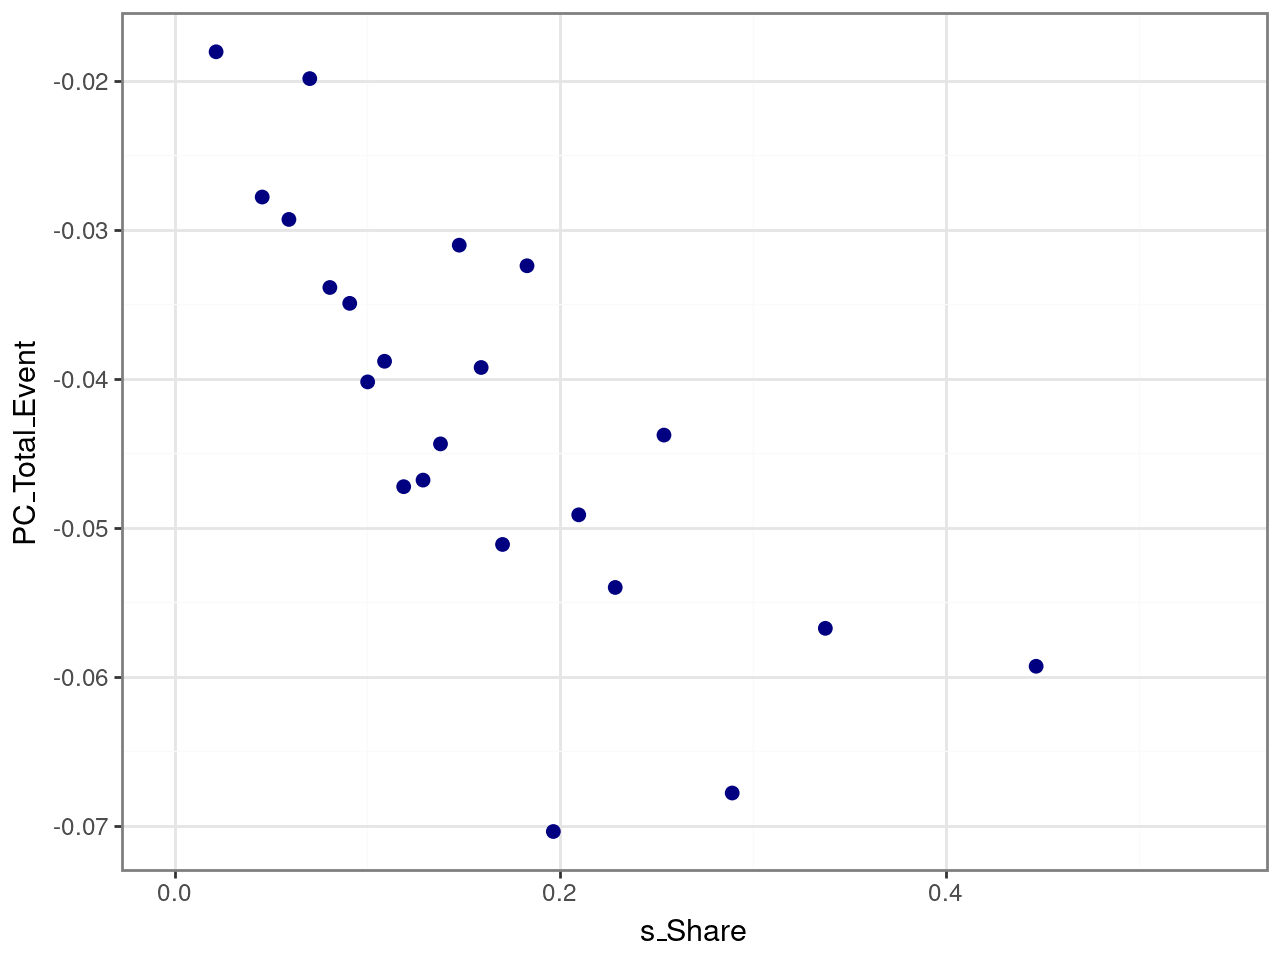

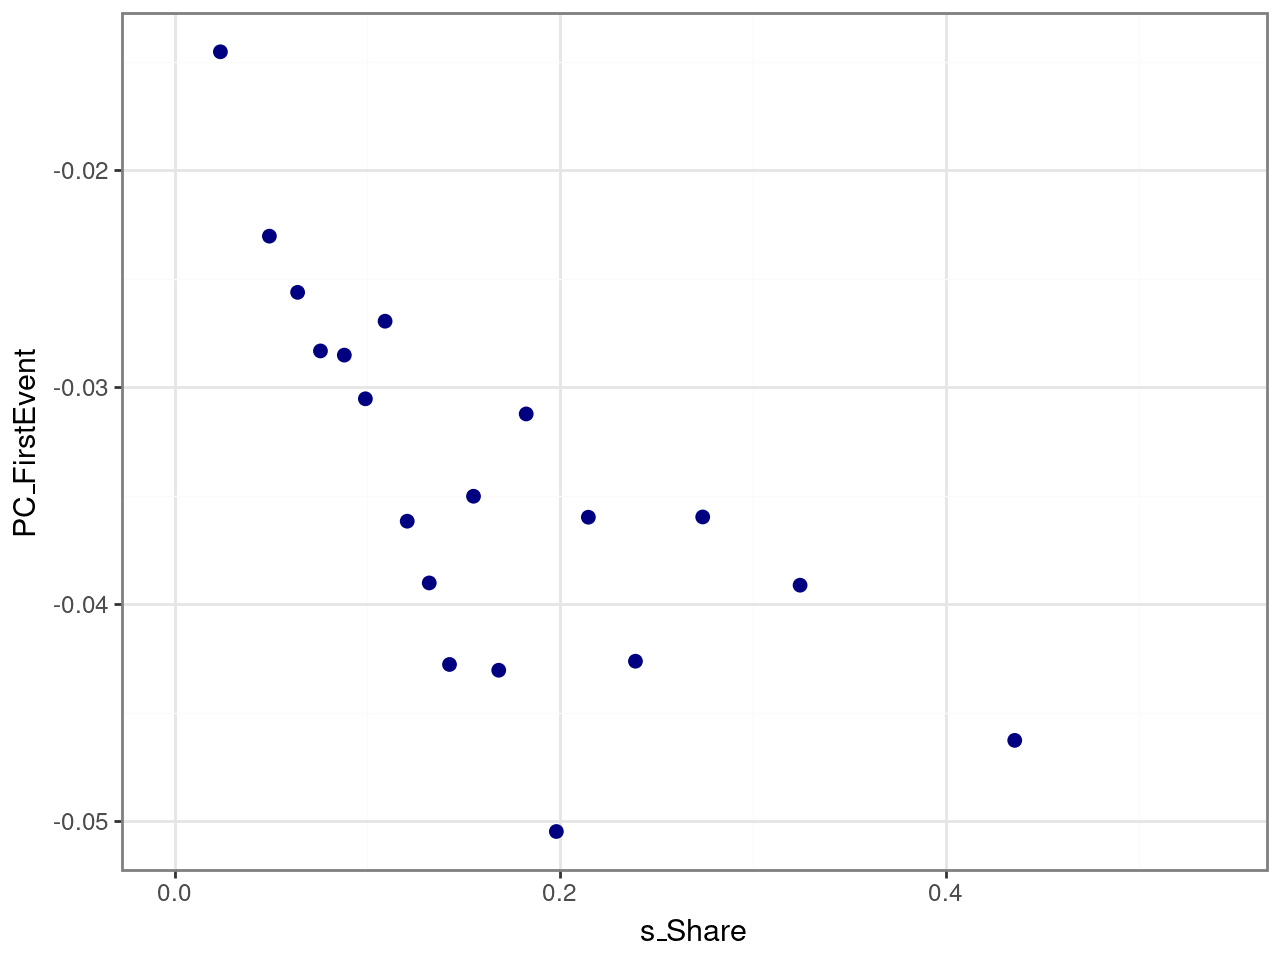

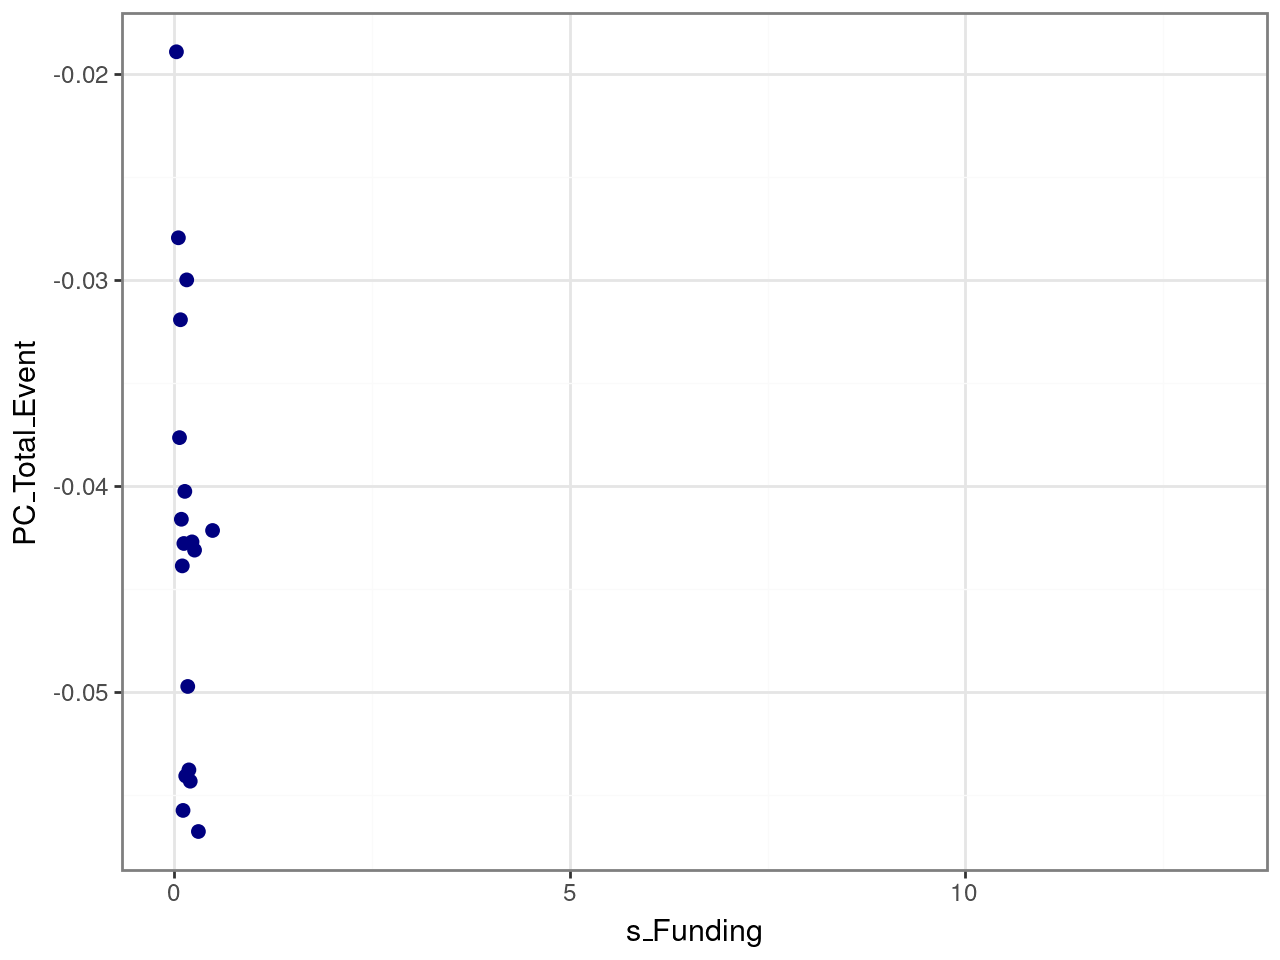

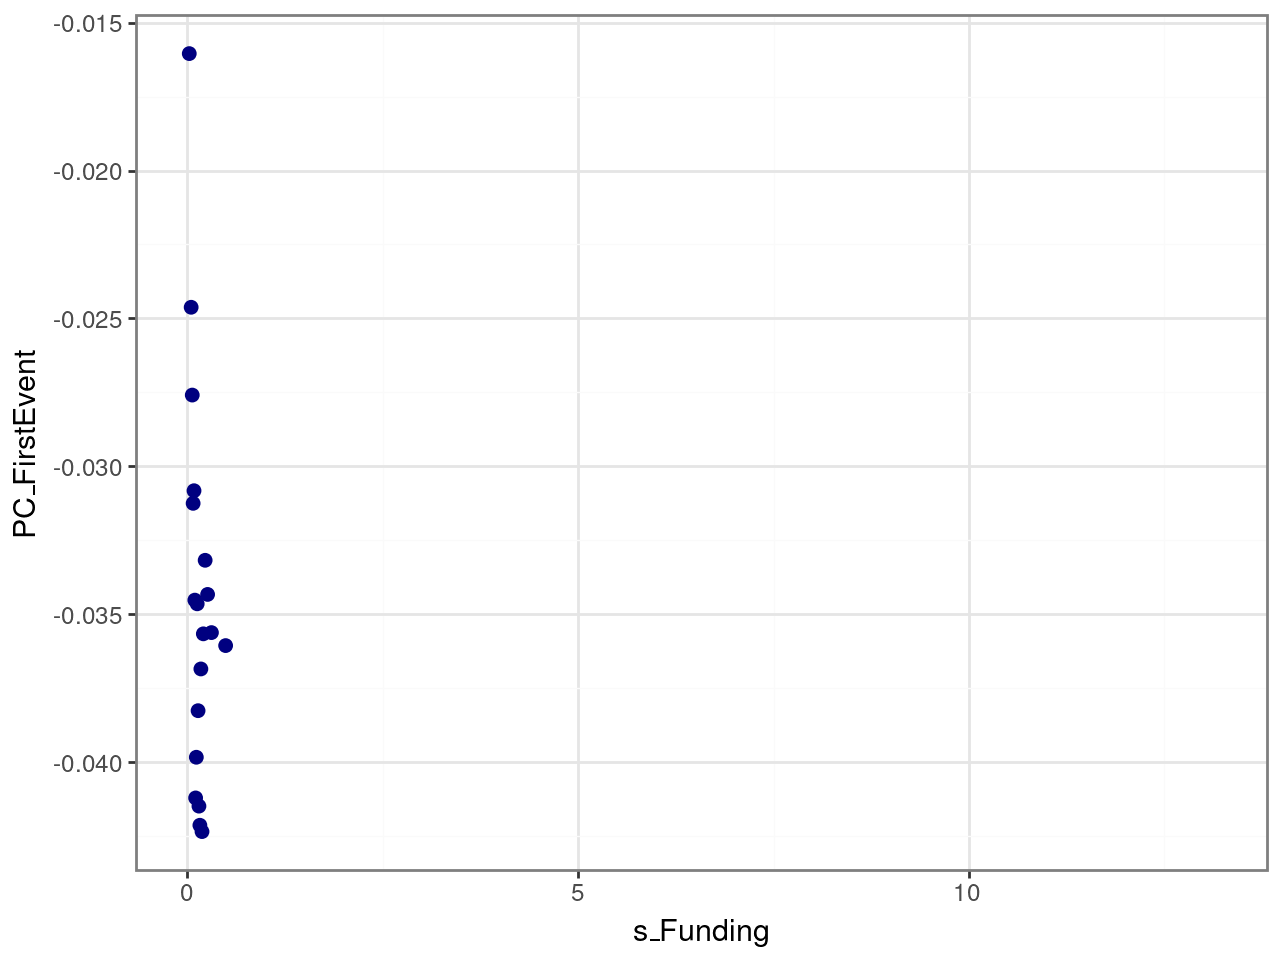

In [32]:
PairList = [(xx, yy) for xx in ['s_Share', 's_Funding'] for yy in ['PC_Total_Event', 'PC_FirstEvent']]

BinScatterData = pd.concat([UnitFun_BinScatterData(DataForBinScatter, xx, yy) for xx, yy in PairList], \
                           axis=1, join='outer', keys=PairList)


C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


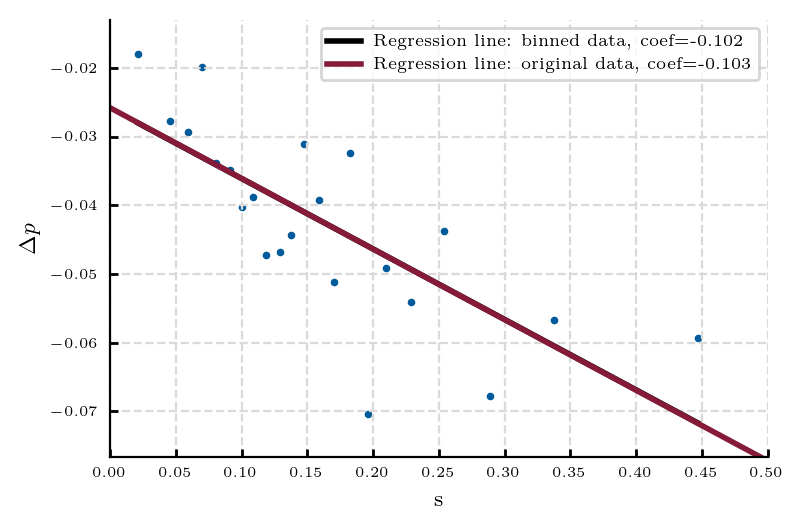

C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


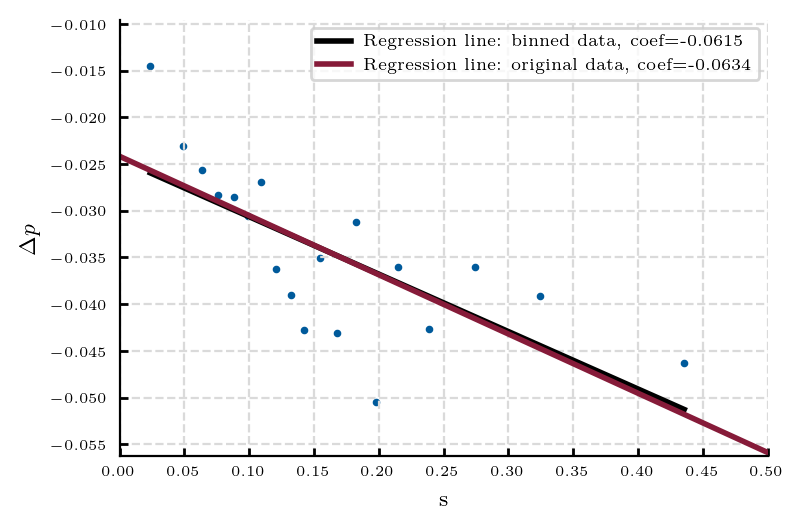

C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


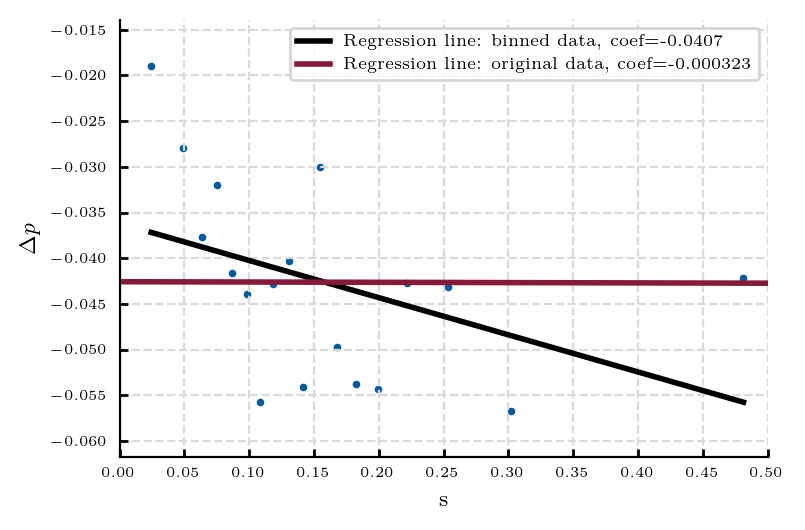

C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


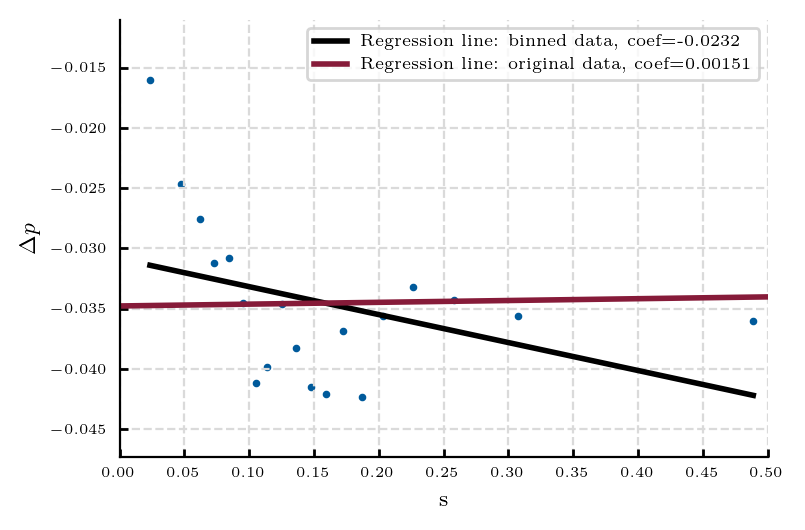

In [33]:
for xx in ['s_Share', 's_Funding']:
    for yy in ['PC_Total_Event', 'PC_FirstEvent']:
        Fig, ax = UnitFun_BinScatterPlot(DataForBinScatter, BinScatterData, xx, yy, XLimit=[0,0.5])
        plt.show()
        Fig.savefig(OutputFolder+'BinScatter_'+xx+'_'+yy+'.eps', format='eps', dpi=1000)

### Winsorized version: drop the outliner with issuance size above 0.5

In [34]:
# tempDS = DataForBinScatter.loc[DataForBinScatter['s_Share']<=0.5, :].copy()
tempDS = DataForBinScatter.copy()

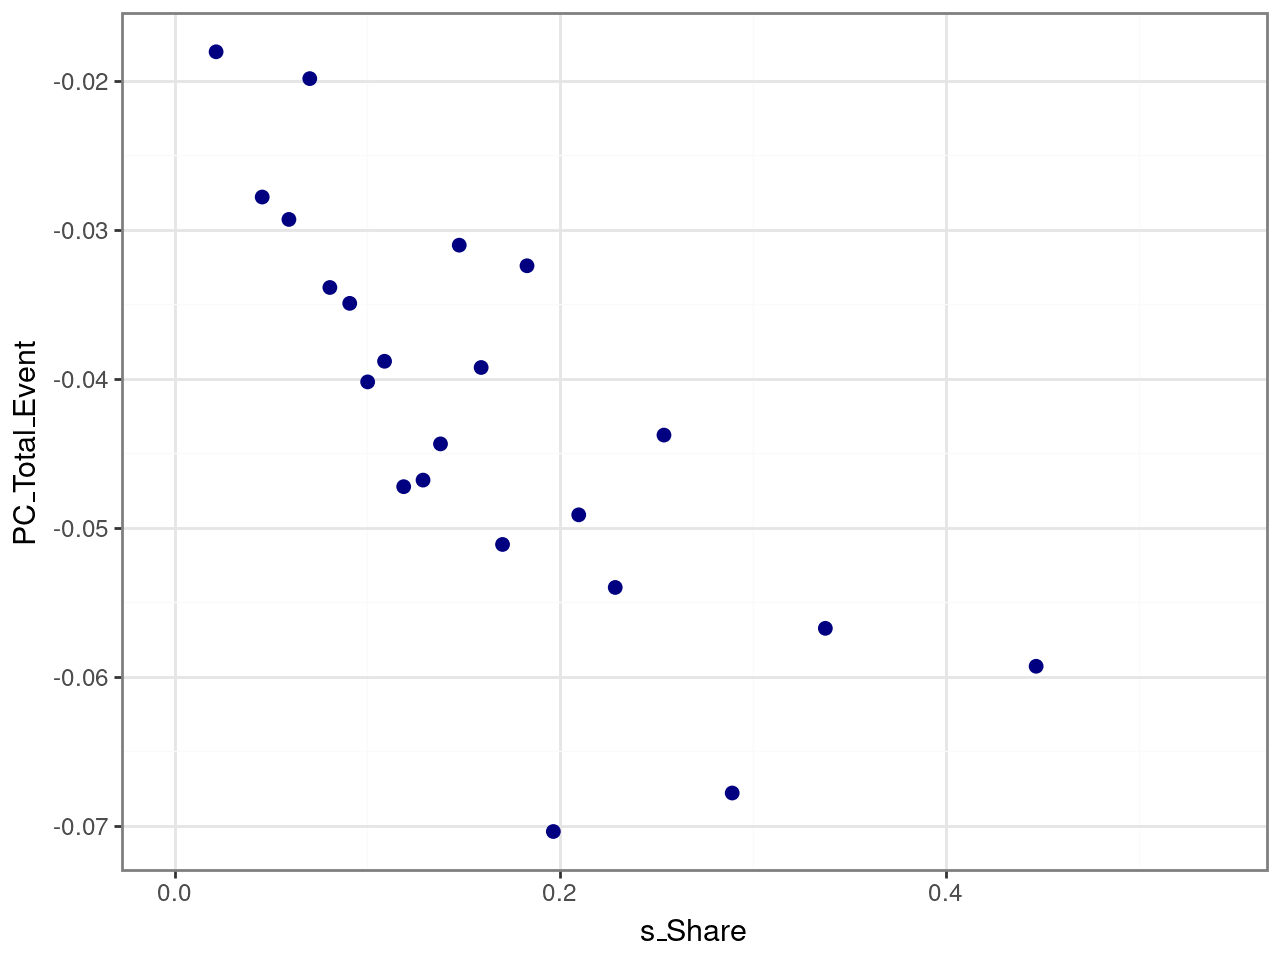

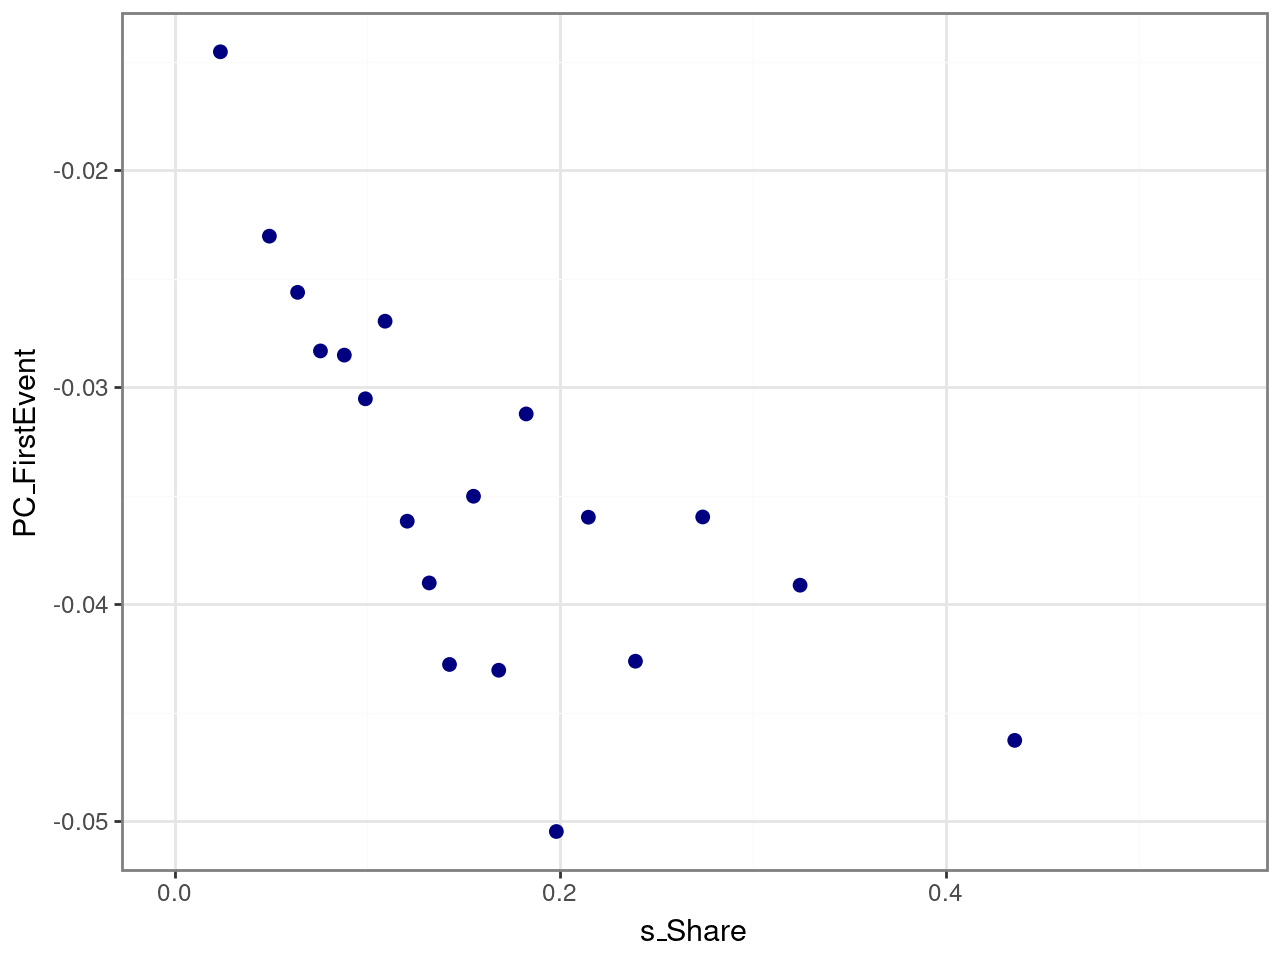

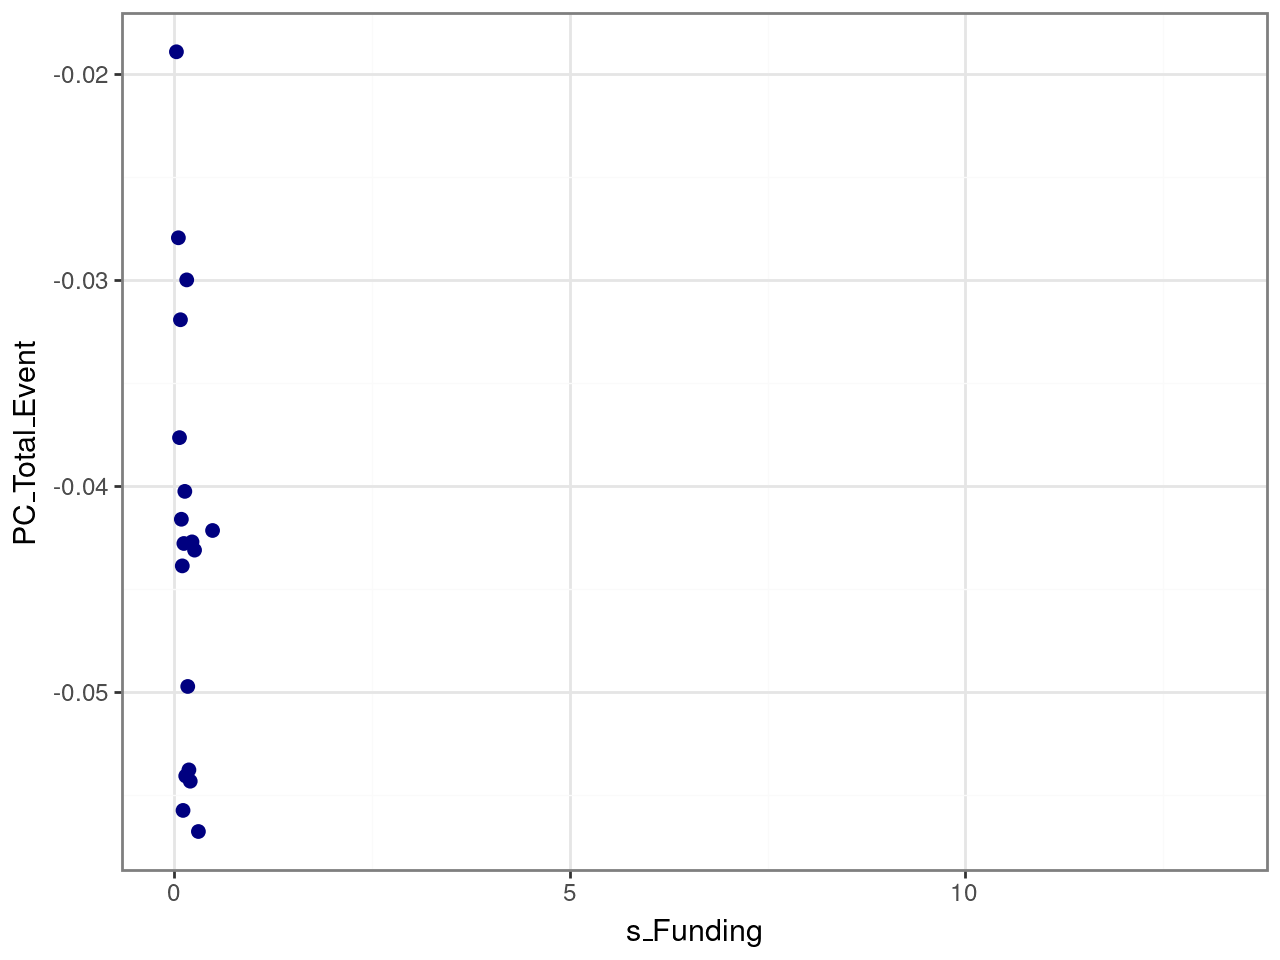

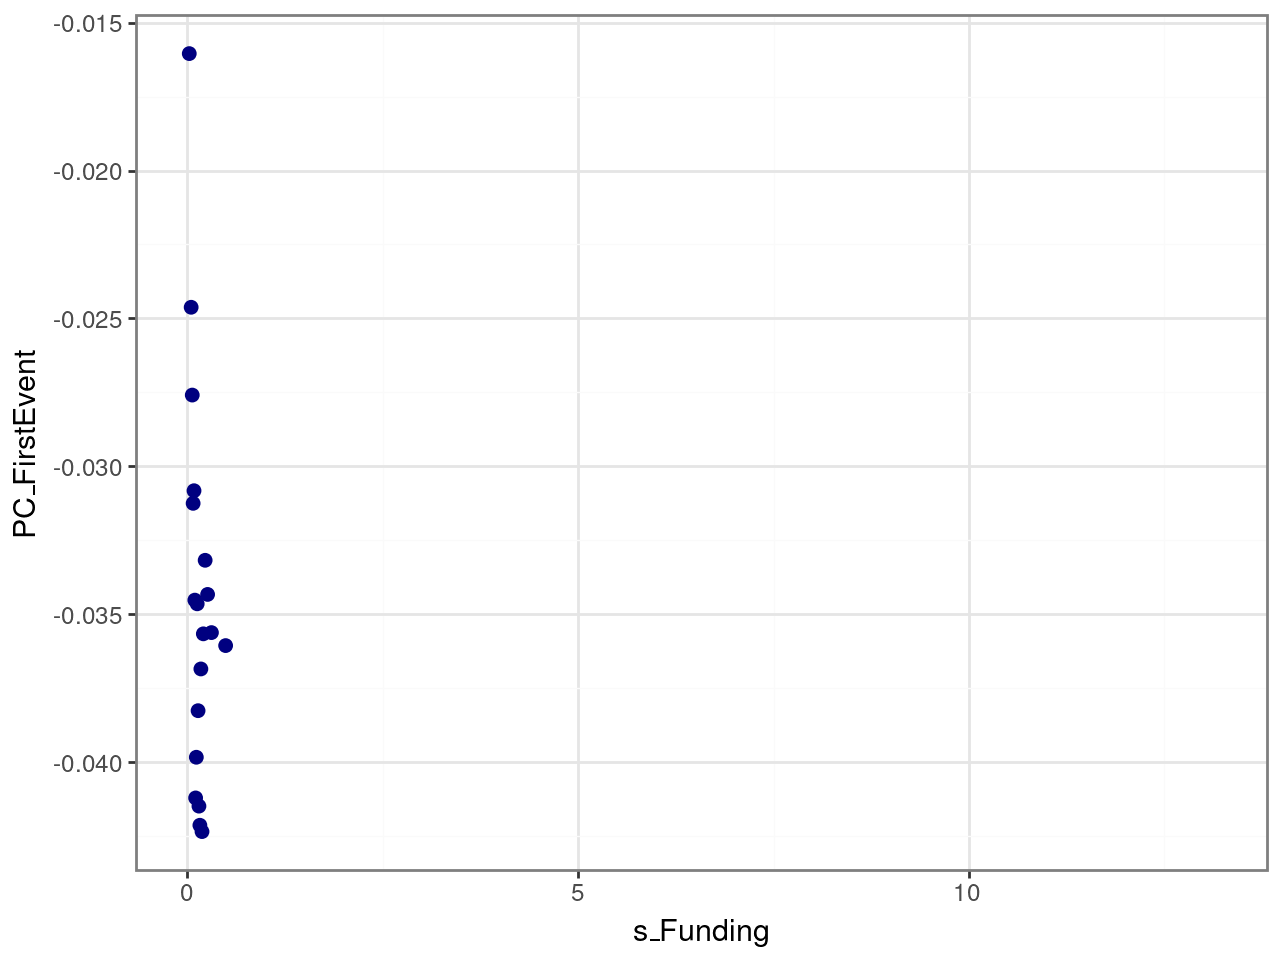

In [35]:
PairList = [(xx, yy) for xx in ['s_Share', 's_Funding'] for yy in ['PC_Total_Event', 'PC_FirstEvent']]

BinScatterData = pd.concat([UnitFun_BinScatterData(tempDS, xx, yy) for xx, yy in PairList], axis=1, join='outer', keys=PairList)


C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


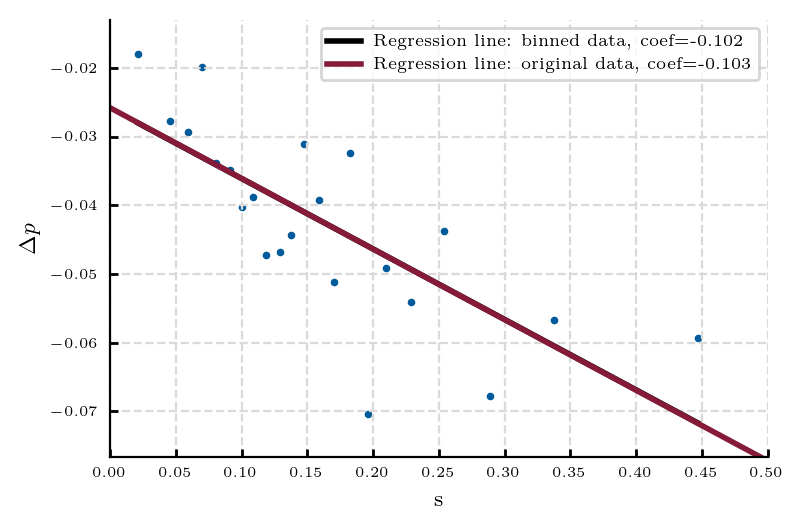

C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


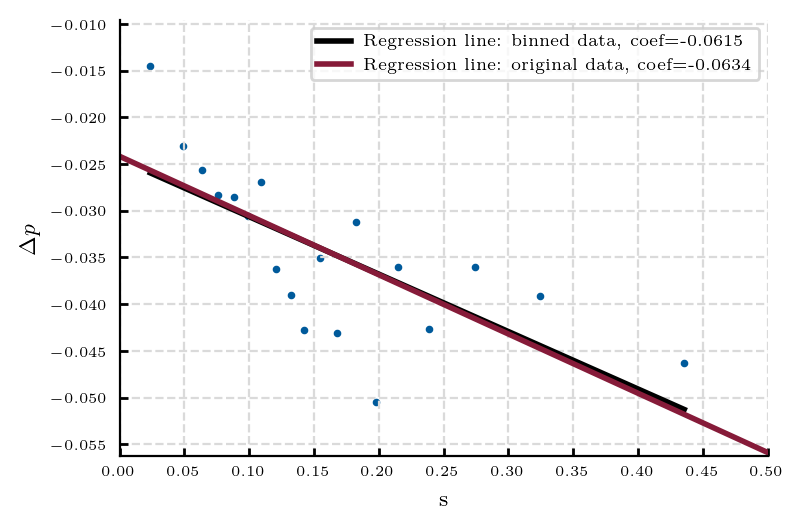

C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


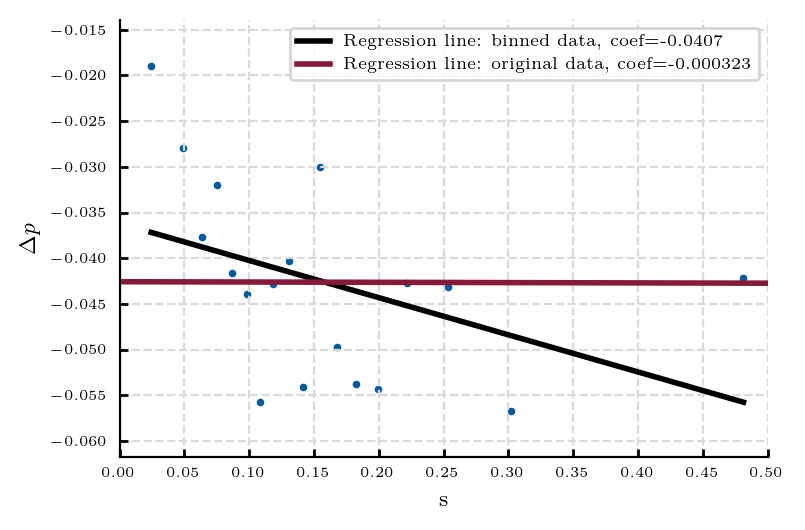

C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


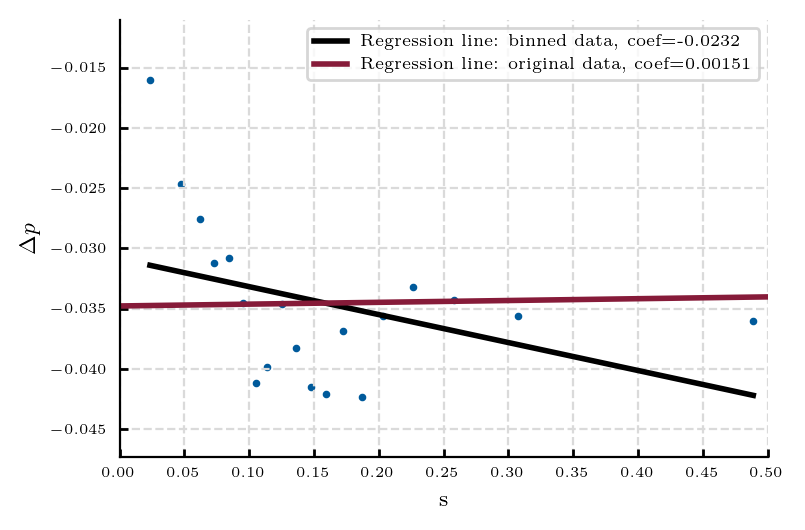

In [36]:
for xx in ['s_Share', 's_Funding']:
    for yy in ['PC_Total_Event', 'PC_FirstEvent']:
        Fig, ax = UnitFun_BinScatterPlot(tempDS, BinScatterData, xx, yy, XLimit=[0,0.5])
        plt.show()
        Fig.savefig(OutputFolder+'BinScatter_'+xx+'_'+yy+'_NoOutliner.eps', format='eps', dpi=1000)

## Runup vs. Price change

In [37]:
# tempDS = DataForBinScatter.loc[DataForBinScatter['s_Share']<=1.5, :].copy()
tempDS = DataForBinScatter.copy()

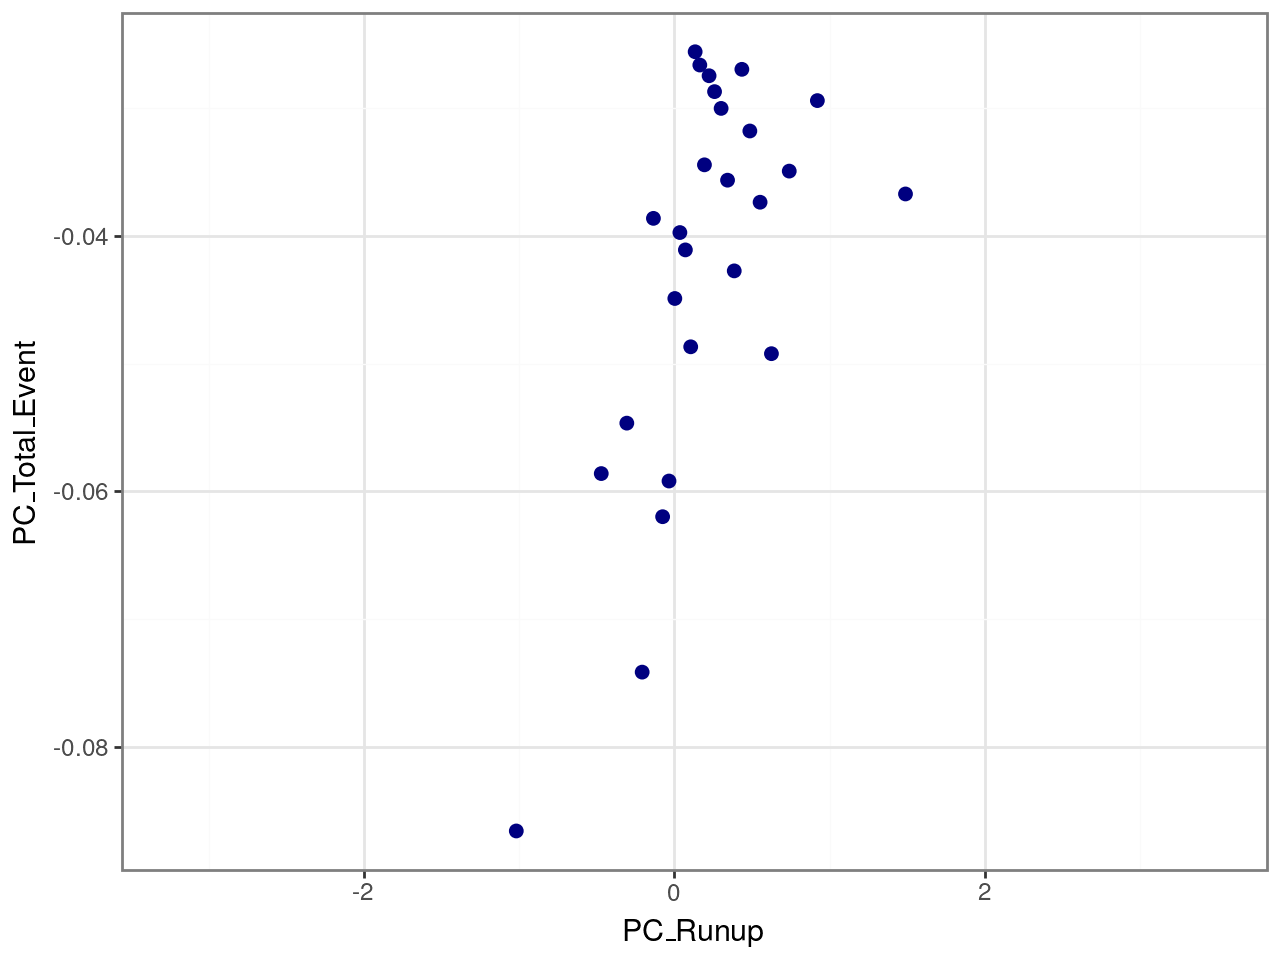

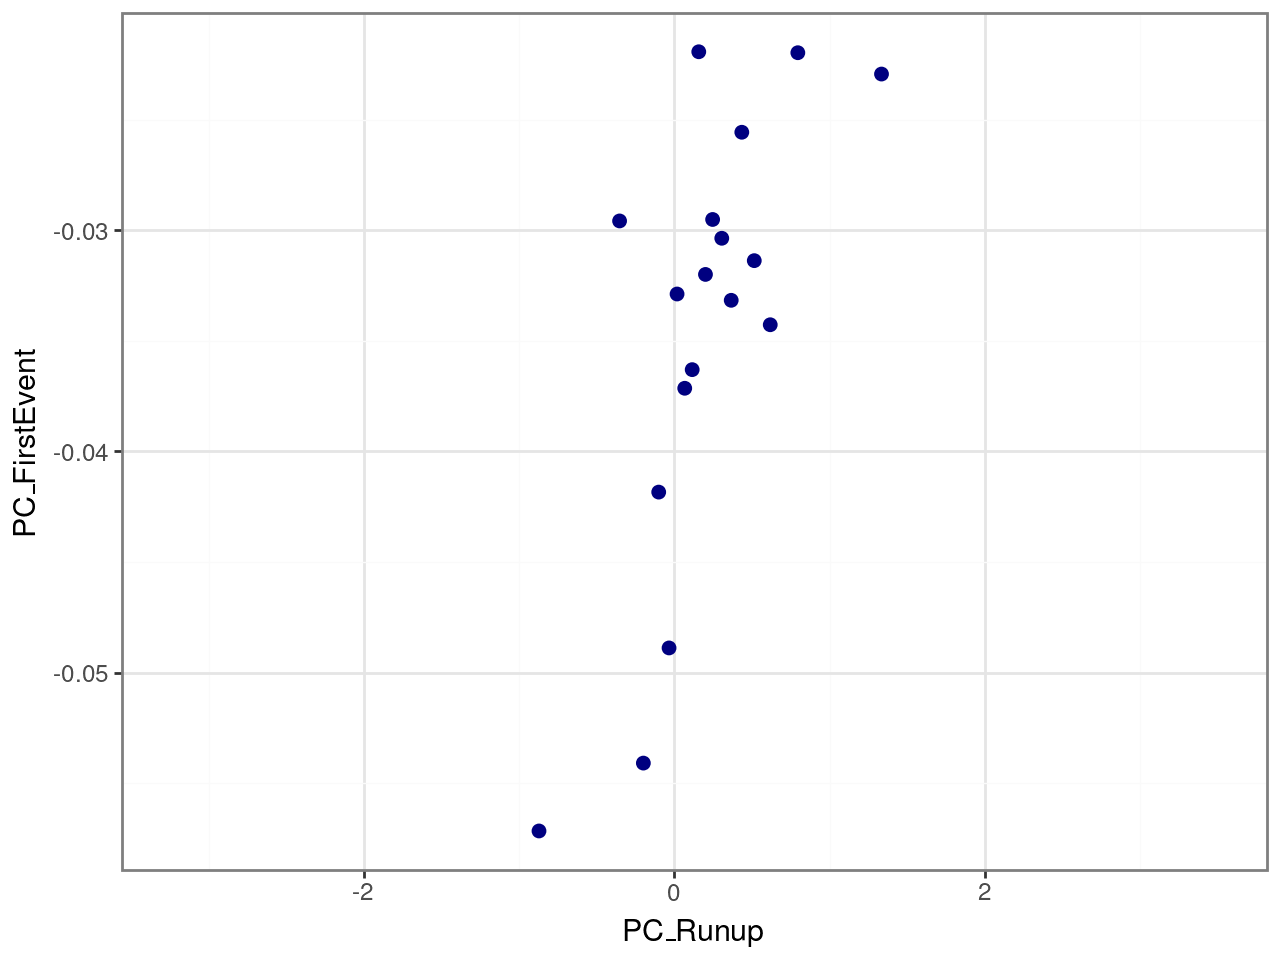

In [38]:
PairList = [(xx, yy) for xx in ['PC_Runup', ] for yy in ['PC_Total_Event', 'PC_FirstEvent']]

BinScatterData = pd.concat([UnitFun_BinScatterData(tempDS, xx, yy) for xx, yy in PairList], axis=1, join='outer', keys=PairList)

C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


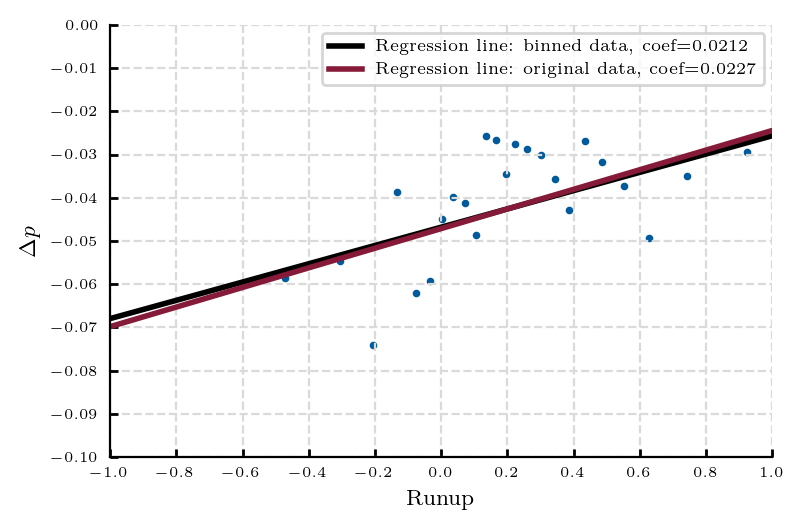

C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


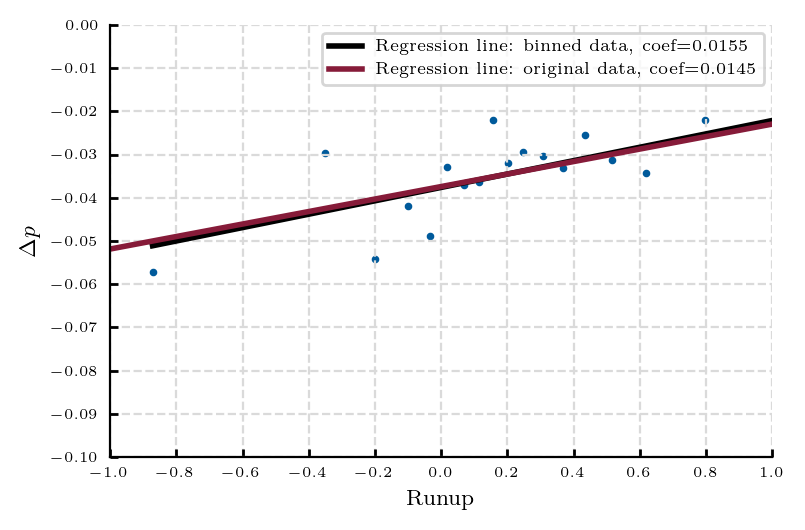

In [39]:
for xx in ['PC_Runup']:
    for yy in ['PC_Total_Event', 'PC_FirstEvent']:
        Fig, ax = UnitFun_BinScatterPlot(DataForBinScatter, BinScatterData, xx, yy, XLabel='Runup', XLimit=[-1, 1], YLimit=[-0.10, 0.0])
        Fig.savefig(OutputFolder+'BinScatter_'+xx+'_'+yy+'.eps', format='eps', dpi=1000)
        plt.show()

## LogK vs. Price Change

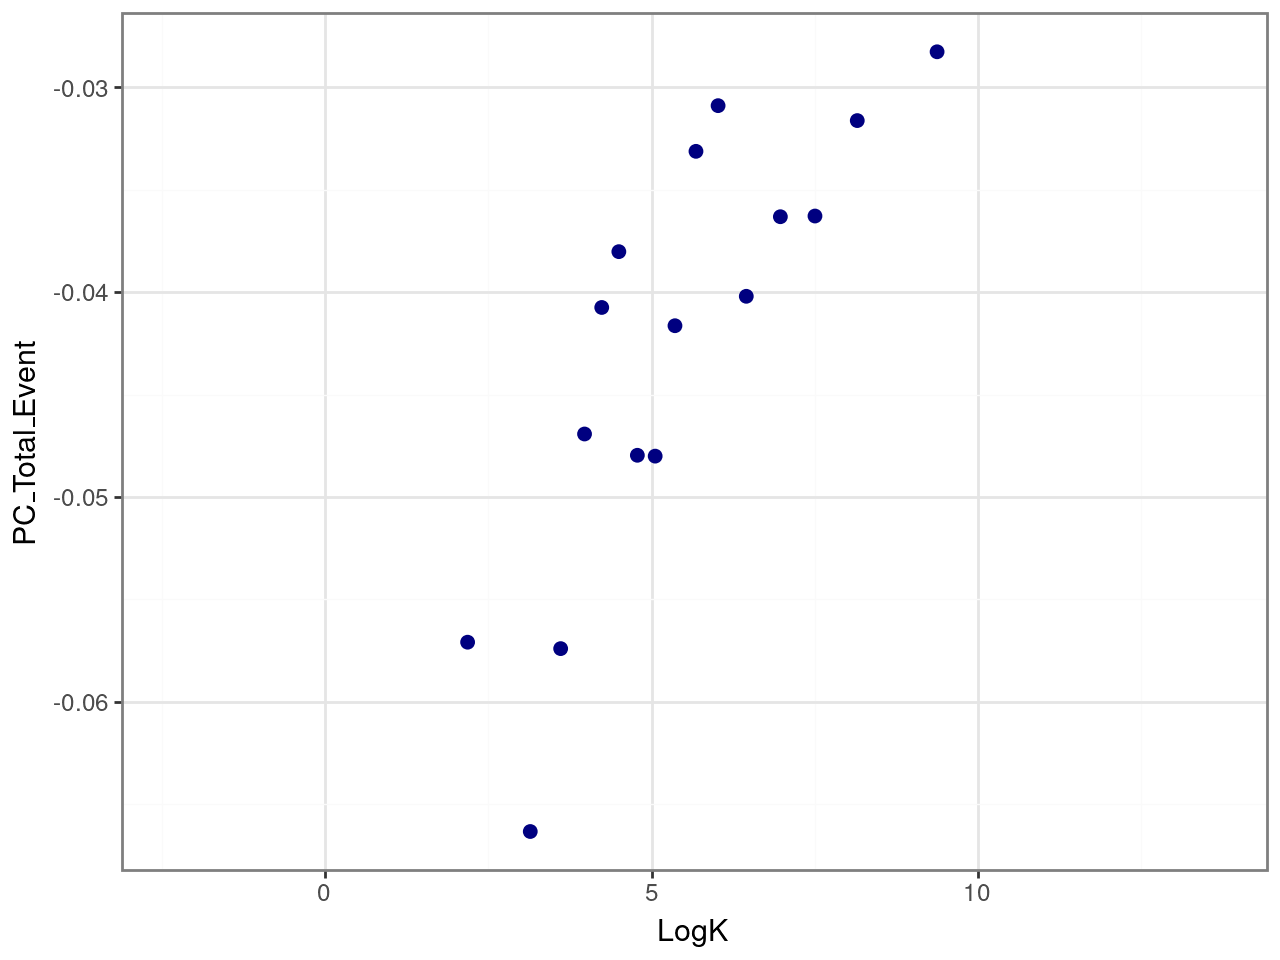

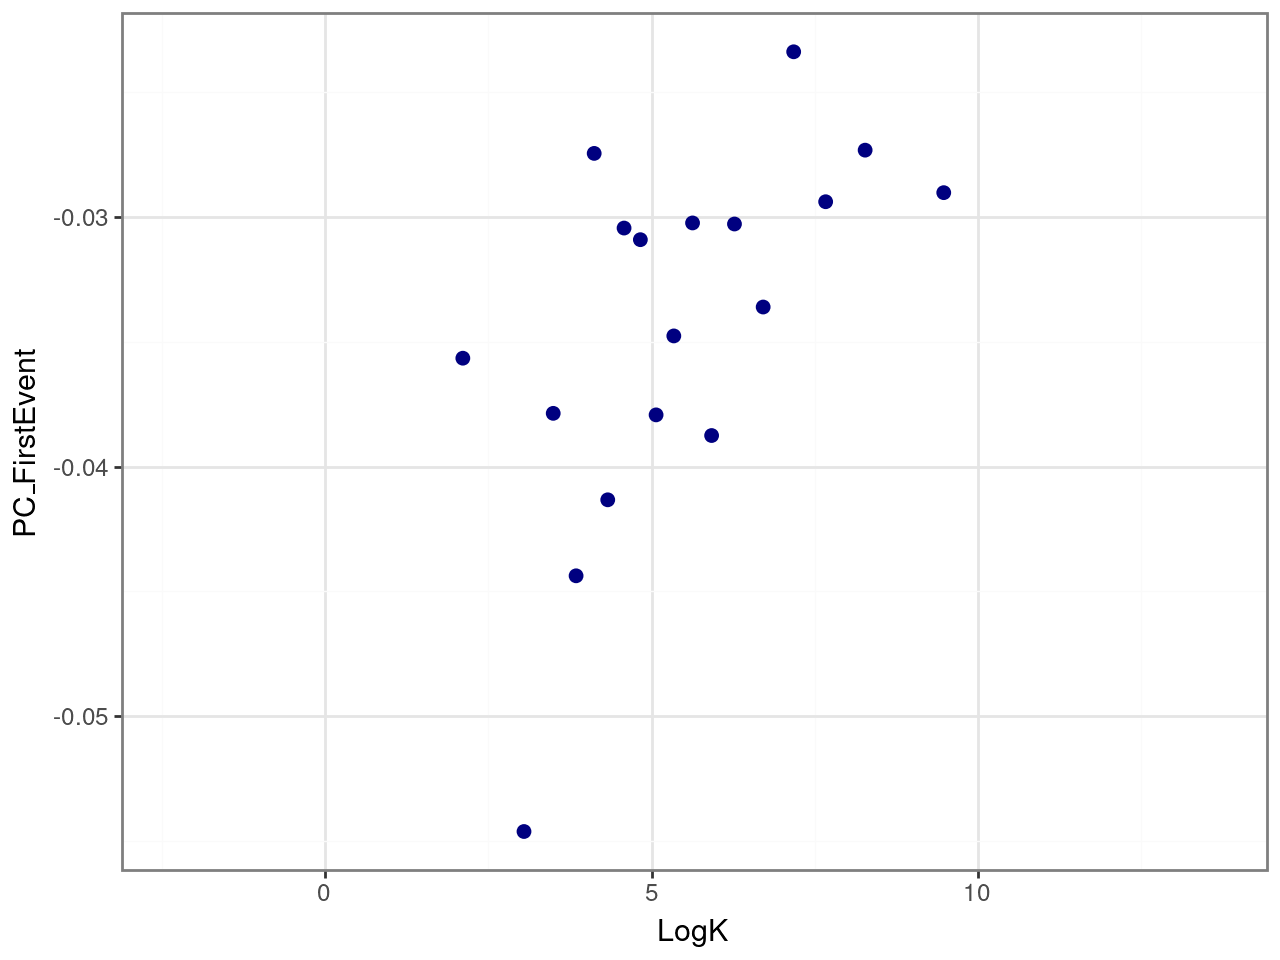

In [40]:
PairList = [(xx, yy) for xx in ['LogK', ] for yy in ['PC_Total_Event', 'PC_FirstEvent']]

BinScatterData = pd.concat([UnitFun_BinScatterData(tempDS, xx, yy) for xx, yy in PairList], axis=1, join='outer', keys=PairList)

C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


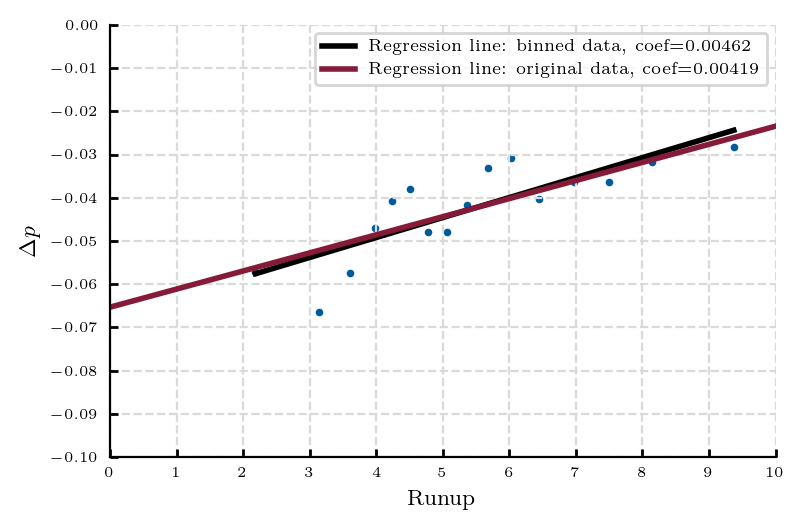

C:\Users\XingGuo\AppData\Local\Temp\ipykernel_19296\1609865369.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.


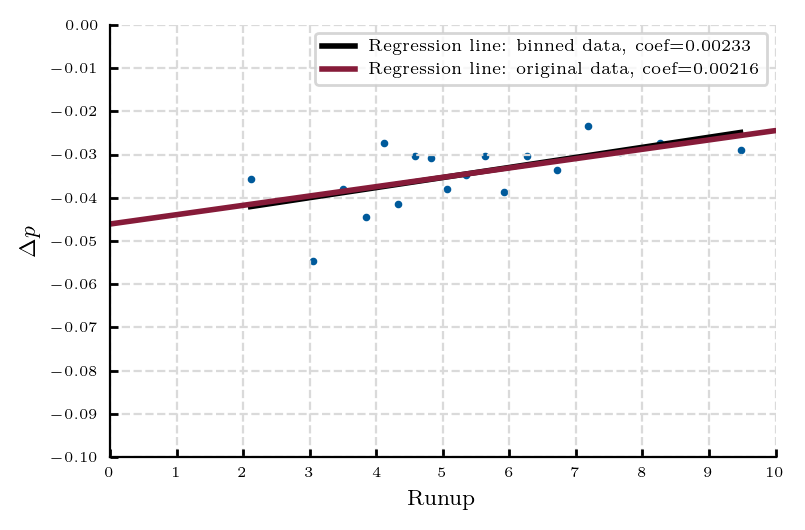

In [41]:
for xx in ['LogK']:
    for yy in ['PC_Total_Event', 'PC_FirstEvent']:
        Fig, ax = UnitFun_BinScatterPlot(DataForBinScatter, BinScatterData, xx, yy, XLabel='Runup', XLimit=[0,10], YLimit=[-0.10, 0.0])
        Fig.savefig(OutputFolder+'BinScatter_'+xx+'_'+yy+'.eps', format='eps', dpi=1000)
        plt.show()

In [42]:
fit = pf.feols("LogK ~ LogProceeds | IssueDate_Quarter + ShelfIssueFlag + FF10_Code", data=DS)
fit.summary()

###

Estimation:  OLS
Dep. var.: LogK, Fixed effects: IssueDate_Quarter+ShelfIssueFlag+FF10_Code
Inference:  CRV1
Observations:  3109

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| LogProceeds   |      0.989 |        0.025 |    40.054 |      0.000 |  0.940 |   1.038 |
---
RMSE: 0.928 R2: 0.755 R2 Within: 0.609 


In [43]:
RegData = fit._data
RegData['LogK_Res'] = fit.resid()

In [44]:
fit = pf.feols("PC_Total_Event ~ LogProceeds | IssueDate_Quarter + ShelfIssueFlag + FF10_Code", data=RegData)
fit.summary()

###

Estimation:  OLS
Dep. var.: PC_Total_Event, Fixed effects: IssueDate_Quarter+ShelfIssueFlag+FF10_Code
Inference:  CRV1
Observations:  3109

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| LogProceeds   |      0.011 |        0.002 |     6.091 |      0.000 |  0.007 |   0.014 |
---
RMSE: 0.096 R2: 0.089 R2 Within: 0.017 


In [45]:
RegData['PC_Total_Event_Res'] = fit.resid()

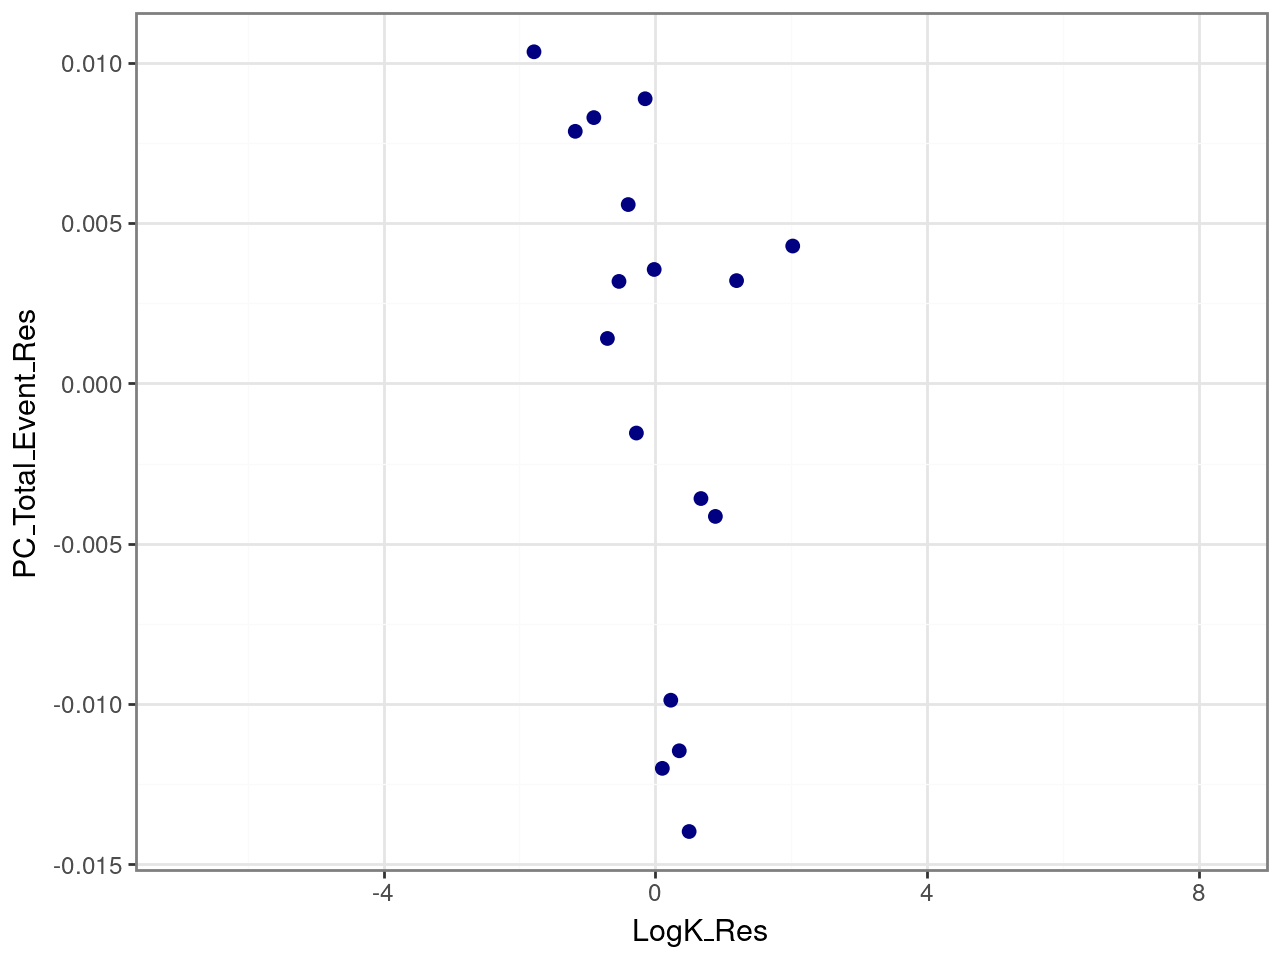

,x,fit
0,-1.785994,0.010342
1,-1.178577,0.007861
2,-0.905184,0.008289
3,-0.705401,0.001401
4,-0.534971,0.003181
5,-0.399056,0.005577
6,-0.278711,-0.001548
7,-0.149936,0.008877
8,-0.016679,0.003553
9,0.103071,-0.012005


In [46]:
UnitFun_BinScatterData(RegData, 'LogK_Res', 'PC_Total_Event_Res')

In [47]:
fit = pf.feols("PC_Total_Event ~ LogProceeds + LogK + s_Share | IssueDate_Quarter + ShelfIssueFlag + FF10_Code", data=DS)
fit.summary()

###

Estimation:  OLS
Dep. var.: PC_Total_Event, Fixed effects: IssueDate_Quarter+ShelfIssueFlag+FF10_Code
Inference:  CRV1
Observations:  3109

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| LogProceeds   |      0.017 |        0.003 |     5.387 |      0.000 |  0.010 |   0.023 |
| LogK          |     -0.007 |        0.002 |    -3.236 |      0.002 | -0.012 |  -0.003 |
| s_Share       |     -0.124 |        0.026 |    -4.668 |      0.000 | -0.176 |  -0.071 |
---
RMSE: 0.096 R2: 0.101 R2 Within: 0.03 


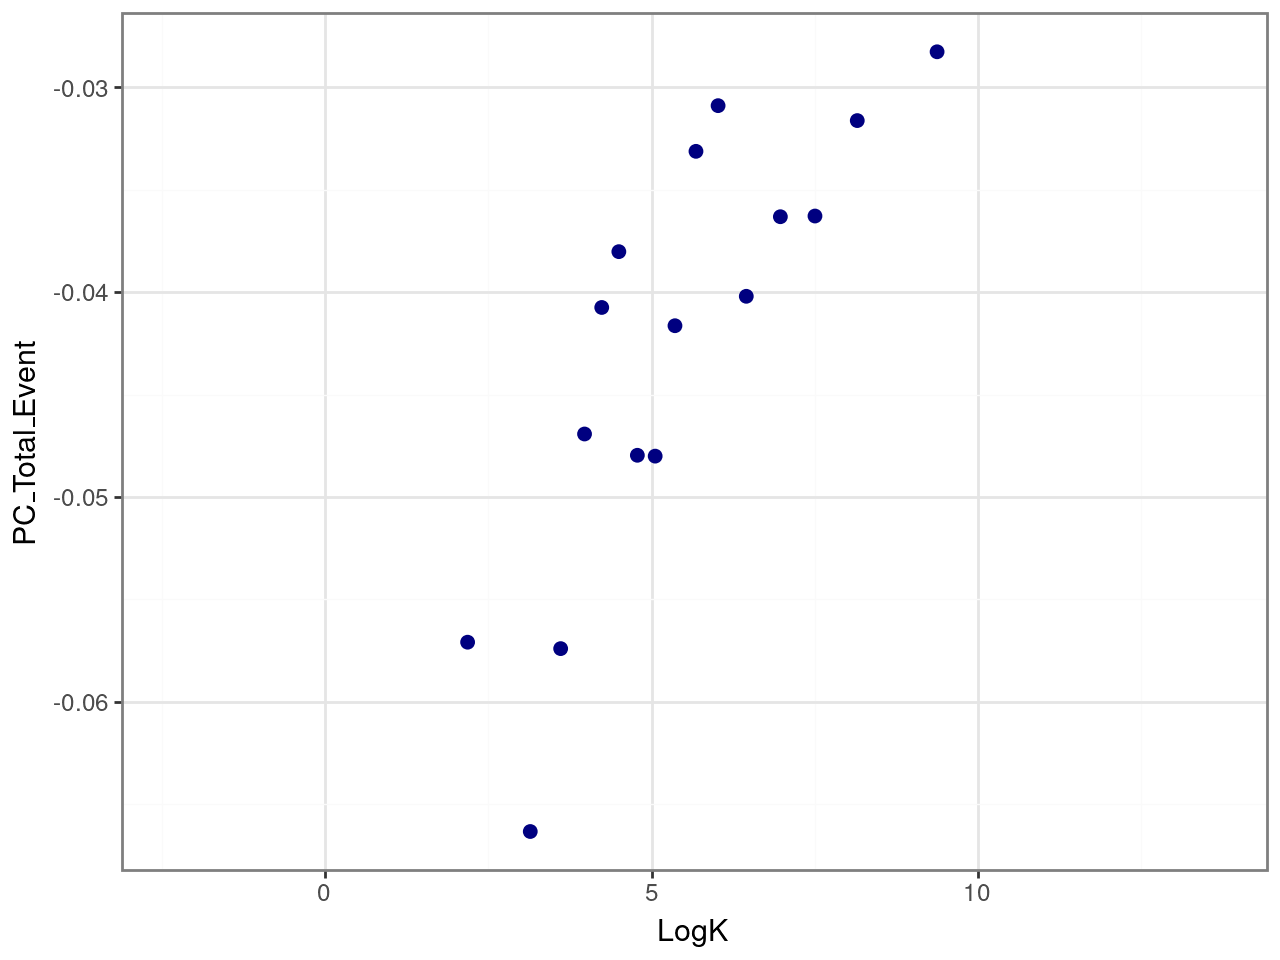

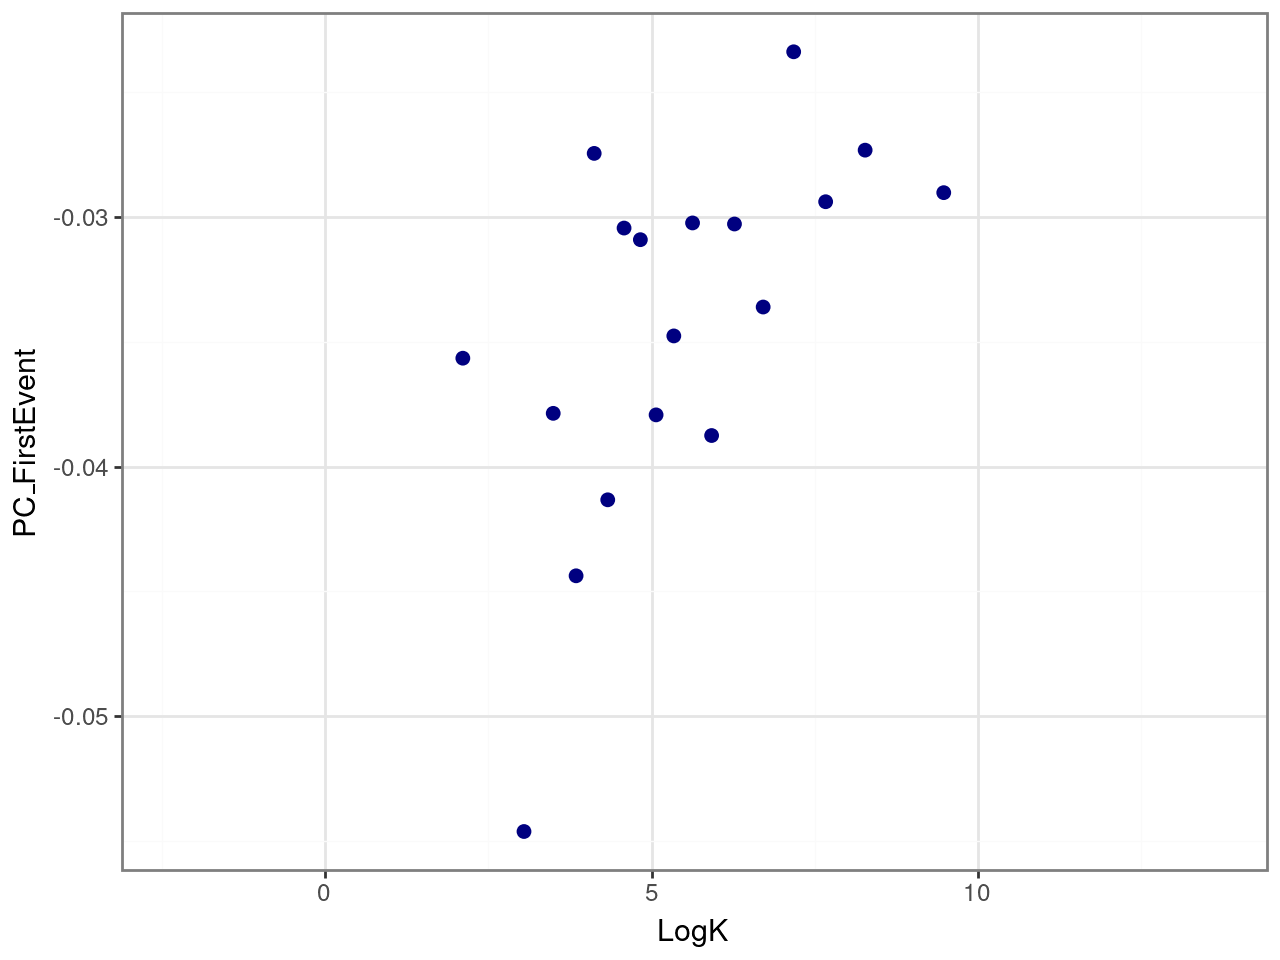

In [48]:
BinScatterData = pd.concat([UnitFun_BinScatterData(tempDS, xx, yy) for xx, yy in PairList], axis=1, join='outer', keys=PairList)


# Time-series of average price drop

In [49]:
def UnitFun_GenDataForPlot(DS, RetVar, WeightVar, DateVar, Scale=100):
    DataForPlot = pd.concat([DS.groupby(DateVar)[RetVar].mean().sort_index().rename('PriceChange_Avg'), \
                         DS.groupby(DateVar).apply(WeightedMean, [RetVar], WeightVar, include_groups=False) \
                            .sort_index()[RetVar].rename('PriceChange_WAvg')], \
                        axis=1).sort_index() * Scale
    DataForPlot.index = pd.to_datetime(DataForPlot.index)
    return DataForPlot

def UnitFun_PlotRetBusinessCycle(DataForPlot):
    Fig = MyGR.Setup_Fig()
    ax = Fig.add_subplot(1,1,1)
    MyGR.Line(Width=2).Plot(DataForPlot.index, DataForPlot['PriceChange_WAvg'], ax=ax, Label="Price change: weighted")
    MyGR.Line(Color="Blue", Style="dashed", Width=1).Plot(DataForPlot.index, DataForPlot['PriceChange_Avg'], ax=ax, Label="Price change: non-weighted")

    ax.set_xlim([datetime.date(1983,1,1),datetime.date(2015,12,31)])
    ax.set_ylabel('Percent', fontsize=8) 
    ax.set_xlabel('Year', fontsize=8)
    ax.tick_params(axis='both', labelsize=5)
    MyGR.NBER_RecessionBar(ax)
    MyGR.Setup_Ax(ax, XDateFlag=True, XTickNbins=10)
    plt.legend(loc='lower left', fontsize=6)

    plt.tight_layout()

    return Fig, ax

In [50]:
def UnitFun_KeyBusinessCycleResults(DS, RetVar, DateVar, WeightVar='s_Share'):
    DataForPlot = UnitFun_GenDataForPlot(DS, RetVar, WeightVar, DateVar)
    AvgPriceChangeStat = DataForPlot.mean()

    TempData = DataForPlot.rolling(4).mean()
    Fig_BusCycle, ax_BusCycle = UnitFun_PlotRetBusinessCycle(TempData)

    KeyResult = {'BusinessCyclePlot': Fig_BusCycle, 'AvgPriceChangeStat': AvgPriceChangeStat}

    return KeyResult

In [51]:
RetVarList = ['PC_Total_Event', 'PC_FirstEvent']
DateVarList = ['IssueDate_Quarter', 'FirstEventDate_Quarter', 'FilingDate_Quarter']
WeightVar = 's_Share'

## Generate the data for plots

In [52]:
DataForPlotDict = {}
for DateVar in DateVarList:
    DataForPlotDict[DateVar] = {}
    for RetVar in RetVarList:
        DataForPlot = UnitFun_GenDataForPlot(DS, RetVar, WeightVar, DateVar)
        DataForPlotDict[DateVar][RetVar] = DataForPlot
   

In [53]:
TempIdx = pd.MultiIndex.from_product([DateVarList, RetVarList], names=['DateVar', 'RetVar'])
AvgPriceChangeStat = pd.concat([DataForPlotDict[Idx[0]][Idx[1]].mean() for Idx in TempIdx], axis=1, join='outer', keys=TempIdx)
AvgPriceChangeStat

DateVar          IssueDate_Quarter               FirstEventDate_Quarter  \
RetVar              PC_Total_Event PC_FirstEvent         PC_Total_Event   
PriceChange_Avg          -3.744946     -3.071745              -3.648871   
PriceChange_WAvg         -4.306132     -3.461270              -4.299330   

DateVar                        FilingDate_Quarter                
RetVar           PC_FirstEvent     PC_Total_Event PC_FirstEvent  
PriceChange_Avg      -3.128662          -3.679379     -3.107248  
PriceChange_WAvg     -3.541170          -4.255702     -3.477705

In [54]:
AvgPriceChangeStat.to_latex(OutputFolder+'AvgPriceChangeStat.tex', float_format="%.3g", escape=True)

## Plots

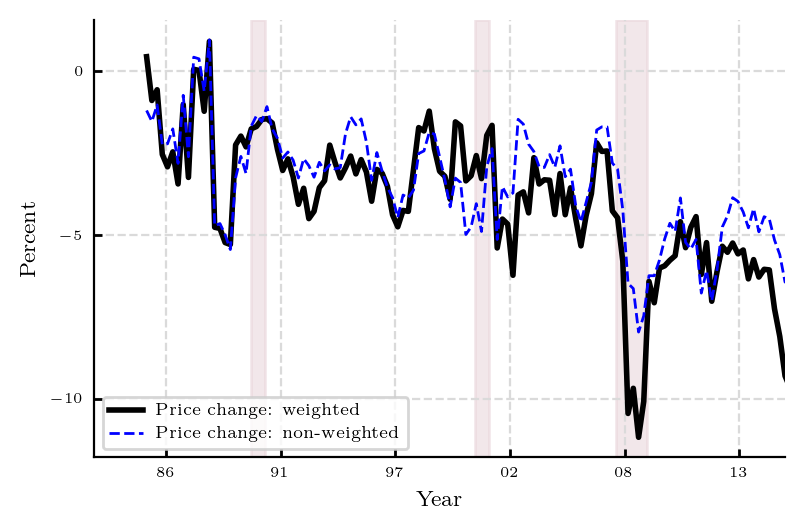

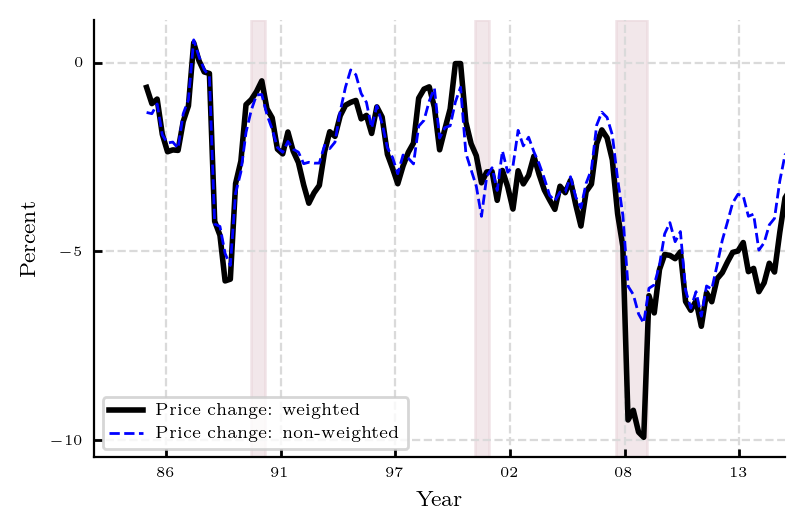

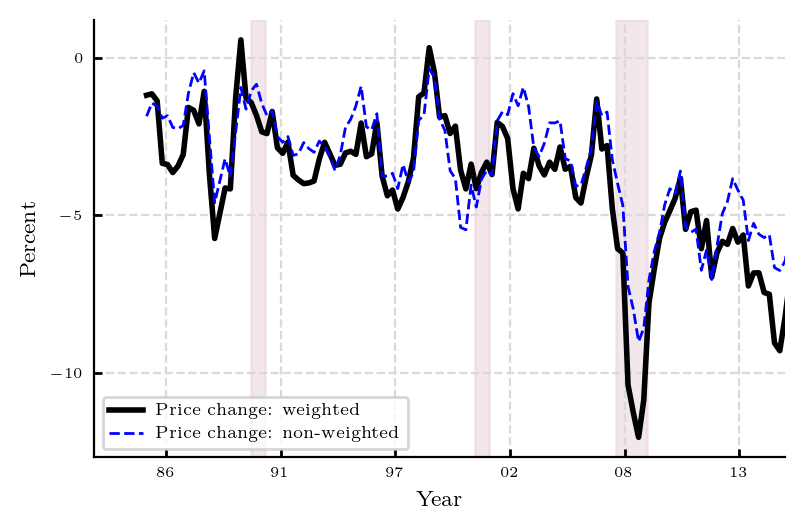

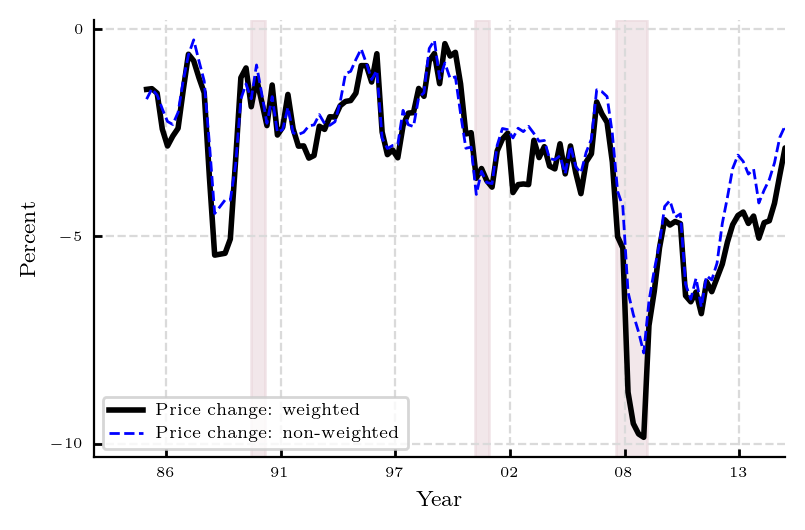

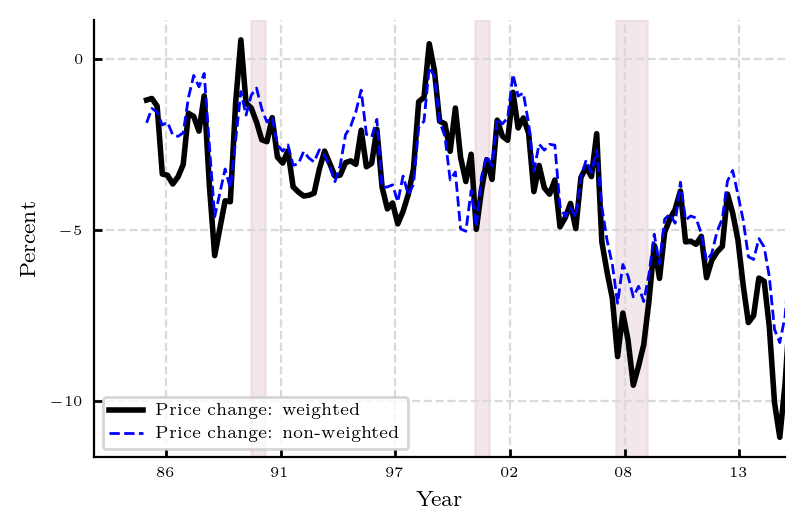

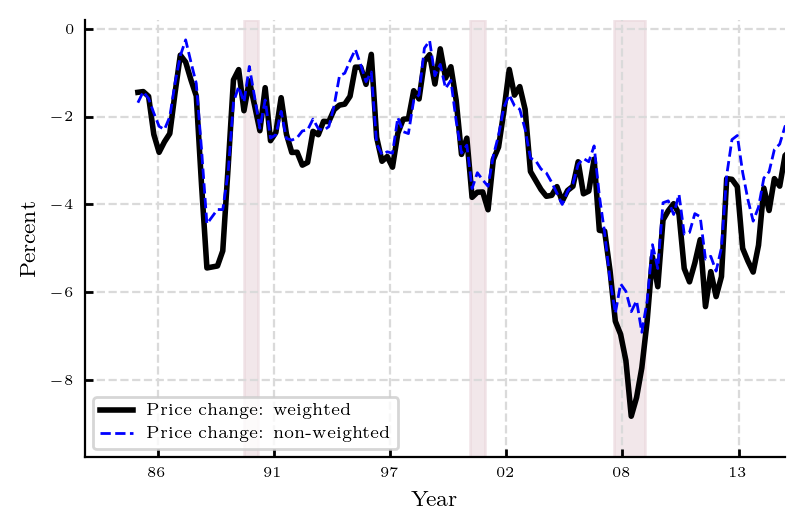

In [55]:
for DateVar in DateVarList:
    for RetVar in RetVarList:
        TempData = DataForPlotDict[DateVar][RetVar].copy()
        # TempData = TempData - TempData.mean()
        TempData = TempData.rolling(4, center=True).mean()
        Fig, ax = UnitFun_PlotRetBusinessCycle(TempData)
        plt.show()
        Fig.savefig(OutputFolder+'/BusinessCycle_PriceChange_'+DateVar+'_'+RetVar+'.eps', format='eps', dpi=1000)              

## Previous results

In [56]:
RetVar = 'PC_PreVersion'
DateVar = 'Date_PreVersion'

In [57]:
DataForPlot.rolling(4)

Rolling [window=4,center=False,axis=0,method=single]

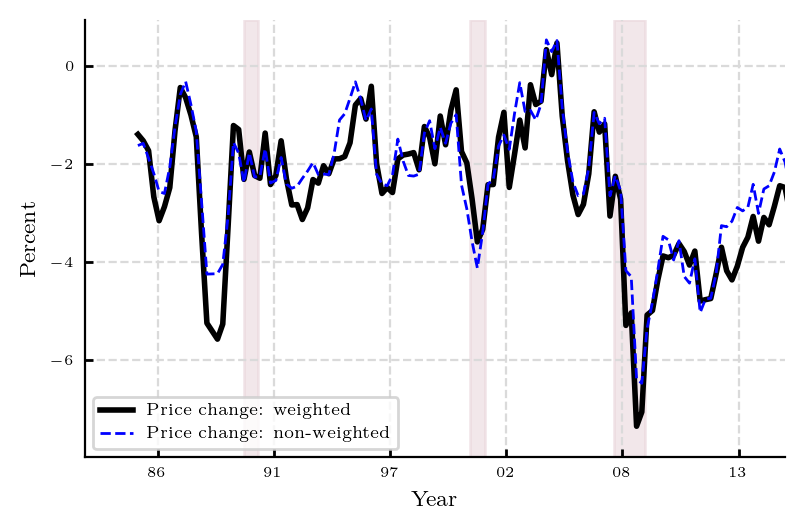

In [58]:
DataForPlot = UnitFun_GenDataForPlot(DS, RetVar, WeightVar, DateVar)
TempData = DataForPlot.rolling(4, center=True).mean()
Fig, ax = UnitFun_PlotRetBusinessCycle(TempData)
plt.show()
Fig.savefig(OutputFolder+'/BusinessCycle_PriceChange_'+DateVar+'_'+RetVar+'.eps', format='eps', dpi=1000)       

# BELOW IS UNCLEANED

# Checks for the business cycle plot

## HP filter

## Original measurement 

In [59]:
def UnitFun_KeyPriceChangeResults(DS, RetVar, DateVar):
    # Step 0. Winsorize the data 
    TempVarList = [RetVar, 's_Share', 's_Funding']

    TempStat = DS[TempVarList].describe(percentiles=PctList)

    TempFlag = True 
    for vv in TempVarList:
        if TempFlag:
            SampleFlag = DS[vv].between(TempStat.loc['0.5%', vv], TempStat.loc['99.5%', vv])
            TempFlag = False
        else:
            SampleFlag = SampleFlag & DS[vv].between(TempStat.loc['0.5%', vv], TempStat.loc['99.5%', vv])
    # Step 1. Summary statistics of price change 
    SumStat = KeyRetStat(DS.loc[SampleFlag, RetVar])

    # Step 2. Binscatter plot 
    DataForBinScatter = DS.loc[SampleFlag, :]
    DataForBinScatter = DataForBinScatter.loc[DataForBinScatter['s_Share']<=0.5, :]

    PairList = [(xx, yy) for xx in ['s_Share',] for yy in [RetVar,]]
    BinScatterData = pd.concat([UnitFun_BinScatterData(DataForBinScatter, xx, yy) for xx, yy in PairList], axis=1, join='outer', keys=PairList)
    Fig_BinScatter, ax_BinScatter = UnitFun_BinScatterPlot(DataForBinScatter, BinScatterData, 's_Share', RetVar, XLimit=[0,0.5])

    # Step 3. Business cycle plot 
    DataForPlot = UnitFun_GenDataForPlot(DS.loc[SampleFlag, :], RetVar, 's_Funding', DateVar)
    AvgPriceChangeStat = DataForPlot.mean()

    TempData = DataForPlot.rolling(4).mean()
    Fig_BusCycle, ax_BusCycle = UnitFun_PlotRetBusinessCycle(TempData)

    KeyResult = {'SumStat': SumStat, 'BinScatterPlot': Fig_BinScatter, \
                'BusinessCyclePlot': Fig_BusCycle, 'AvgPriceChangeStat': AvgPriceChangeStat}

    return KeyResult
